In [42]:
# Author: Caleb Woy

import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt # plotting
import seaborn as sb # plotting
import os # Reading data
import matplotlib.pylab as plt # plotting hyperparamter cost curves
from sklearn.model_selection import RandomizedSearchCV 
# tuning hyperparams for complex models
from sklearn.metrics import make_scorer 
# defining custom model evaluation function
from sklearn.model_selection import GridSearchCV 
# tuning hyperparams for simple models
from sklearn import preprocessing # scaling features
import random # random centroid generation

# Loading Data

In [43]:
path_to_data = "C:/Users/woybo/Desktop/jupyter-Nbooks/DM-Clustering"

# Loading the training and test data sets into pandas
small_xy = pd.read_csv(path_to_data + "/small_Xydf.csv", header=0)
small_xy = small_xy.drop(columns=["Unnamed: 0"])

large_xy = pd.read_csv(path_to_data + "/large_Xydf.csv", header=0)
large_xy = large_xy.drop(columns=["Unnamed: 0"])

red_wine = pd.read_csv(path_to_data + "/winequality-red.csv", sep=';', 
                       header=0)
red_wine['y'] = red_wine.apply(lambda x: int(x['quality'] - 3), axis=1)

In [44]:
small_xy.head()

X0        X1  y
0  7.034397  0.284305  2
1  6.816368  2.026816  2
2  6.874073  0.169889  2
3  3.415365  0.840269  0
4 -4.294266 -0.754346  1

In [45]:
large_xy.head()

X0         X1  y
0  7.992881   7.820825  4
1  2.716103   1.934914  1
2 -2.175060   3.811504  2
3  8.113584  11.383508  4
4  6.781734   8.398259  4

In [46]:
red_wine.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  y  
0      9.4        5  2  
1      9.8        5  2  
2      9.8        5  2  
3      9.8        6  3  
4      9.4        5  2

# Implementing K-Means Algorithm

In [47]:
"""
Implementing K-means clustering algorithm from scratch.

data: pandas dataframe, X data to be used for clustering
k: int, the number of centroids to assign
verbose: Boolean, default is true, if false nothing is printed
"""
def Kmeans(data, k, verbose = True):
    random.seed(k)
    if verbose:
        print(f'TESTING FOR K = {k}')
    # scale the x data uniformly
    x = data.values # Get data as np array
    standard_scaler = preprocessing.StandardScaler()
    x_scaled = standard_scaler.fit_transform(x)
    data = pd.DataFrame(x_scaled)
    # calculating the max and min values for each column and storing them in 
    # an array
    min_max = data.apply(lambda x:
        pd.Series(index=['min','max'],data=[x.min(),x.max()]))
    min_max_list = min_max.T.values.tolist()
    # Randomly initialize centroids within max and min range of feature vectors
    centroids = {}
    for i in range(k):
        centroids[i] = [ 
            random.uniform(x[0], x[1]) for x in min_max_list]
    # Create arrays for assignments to check for convergence
    curr = np.array([0 for i in range(data.shape[0])])
    prev = np.array([1 for i in range(data.shape[0])])
    # iterate until assignments don't change
    while not (curr == prev).all():
        # copy current into prev
        prev = np.copy(curr)
        if verbose:
            print(f'.', end=' ')
        # Assignment step
        # iterate over each row in the data 
        for index, row in data.iterrows():
            # set min container and flag
            min_dist, min_centroid = float("inf"), 0
            # iterate over each centroid
            for l in range(k):
                # get the centroid vector
                a = np.array(centroids[l])
                # get the row vector
                b = np.array(row.T.values.tolist())
                # calculate euclidean distance
                dist = np.linalg.norm(a - b)
                # set min distance if min
                if dist < min_dist:
                    min_dist, min_centroid = dist, l
            # assign current datum
            curr[index] = min_centroid
        # Getting the counts of each cluster assignment
        curr_counter = np.array(curr)
        unique, counts = np.unique(curr_counter, return_counts=True)
        counts = dict(zip(unique, counts))
        # init container for new centroids
        new_centroids = {}
        for i in range(k):
            new_centroids[i] = [0 for x in min_max_list]
        # Update step
        # iterate over all data
        for index, row in data.iterrows():
            # retrieve row
            row = row.T.values.tolist()
            # retrieve centroid
            cent = new_centroids[curr[index]]
            # iterate over each dimension of the centroid and accumulate the
            # avg distance
            for j in range(len(cent)):
                cent[j] += row[j] / counts[curr[index]]
            new_centroids[curr[index]] = cent
        # reassign centroid
        centroids = new_centroids
    if verbose:    
        print('FINISHED')
    return curr

## Implement cluster SSE, total SSE, and SSB calculations 

In [48]:
"""
Prints the cluster SSE.

data: pandas dataframe, X data
verbose: Boolean, default is true, if false nothing is printed
"""
def cluster_sse(data, verbose = True):
    # calculating cluster centroids
    labels = data['y']
    counts = labels.value_counts()
    data = data.drop(columns=['y'])
    centroids = {}
    for i in range(len(counts)):
        centroids[i] = [0 for j in range(data.shape[1])]
    for index, row in data.iterrows():
        point = np.array(row.T.values.tolist())
        cent = centroids[labels[index]]
        for j in range(len(cent)):
            cent[j] += row[j] / counts[labels[index]]
        centroids[labels[index]] = cent
    # calculating cluster sse
    sse = [0 for j in range(len(counts))]
    for index, row in data.iterrows():
        a = np.array(centroids[labels[index]])
        b = np.array(row.T.values.tolist())
        dist = np.linalg.norm(a - b)
        sse[labels[index]] += dist
    if verbose:
        print(f'CLUSTER SSE IS: {sse}')
    return sse

In [49]:
"""
Prints the total SSE.

data: pandas dataframe, X data
verbose: Boolean, default is true, if false nothing is printed
"""
def total_sse(data, verbose = True):
    # calculating cluster centroids
    labels = data['y']
    counts = labels.value_counts()
    data = data.drop(columns=['y'])
    centroids = {}
    for i in range(len(counts)):
        centroids[i] = [0 for j in range(data.shape[1])]
    for index, row in data.iterrows():
        point = np.array(row.T.values.tolist())
        cent = centroids[labels[index]]
        for j in range(len(cent)):
            cent[j] += row[j] / counts[labels[index]]
        centroids[labels[index]] = cent
    # calculating cluster sse
    sse = 0
    for index, row in data.iterrows():
        a = np.array(centroids[labels[index]])
        b = np.array(row.T.values.tolist())
        dist = np.linalg.norm(a - b)
        sse += dist
    if verbose:
        print(f'TOTAL SSE IS: {sse}')
    return sse

In [50]:
"""
Prints the cluster SSB.

data: pandas dataframe, X data
verbose: Boolean, default is true, if false nothing is printed
"""
def cluster_ssb(data, verbose = True):
    # calculating cluster centroids
    labels = data['y']
    counts = labels.value_counts()
    data = data.drop(columns=['y'])
    centroids = {}
    for i in range(len(counts)):
        centroids[i] = [0 for j in range(data.shape[1])]
    for index, row in data.iterrows():
        point = np.array(row.T.values.tolist())
        cent = centroids[labels[index]]
        for j in range(len(cent)):
            cent[j] += row[j] / counts[labels[index]]
        centroids[labels[index]] = cent
     # calculating global centroid
    glob_centroid = [0 for j in range(data.shape[1])]
    for index, row in data.iterrows():
        point = np.array(row.T.values.tolist())
        for j in range(len(glob_centroid)):
            glob_centroid[j] += row[j] / data.shape[0]
    # calculating total ssb
    ssb = 0
    a = np.array(glob_centroid)
    for key, b in centroids.items():
        b = np.array(b)
        dist = np.linalg.norm(a - b) * counts[key]
        ssb += dist
    if verbose:
        print(f'TOTAL SSB IS: {ssb}')
    return ssb

## Implement cross tabulation matrix calculation

In [51]:
def cross_tab(clustering1, clustering2):
    print('CROSS TABULATION MATRIX')
    clusters = pd.DataFrame()
    clusters['actual'], clusters['predicted'] = clustering1, clustering2
    counts = clusters.groupby(['predicted', 'actual']).size()
    print('', end='\t')
    for i in range(len(clusters['predicted'].unique())):
        print(f'| c{i}', end='\t')
    print('| predicted')
    for i in range(len(clusters['actual'].unique())):
        print(f'c{i}', end='\t')
        for j in range(len(clusters['predicted'].unique())):
            if i in counts[j]:
                print(f'| {counts[j][i]}', end='\t')
            else:
                print('| 0', end='\t')
        print()
    print('actual')
    print()

## Implement Testing Functions

In [52]:
def test_Kmeans_small_large(data, k_collection, k_special = 0):
    x = data.drop(columns=['y'])
    for k in k_collection:
        x['y'] = Kmeans(x, k)
        # Calculating test SSE, SSB
        cluster_sse(x)
        sse = total_sse(x)
        ssb = cluster_ssb(x)
        print(f'SSE RATIO: {sse / (sse + ssb)}')
        if k == k_special:
            plt.scatter(x['X0'], x['X1'], c=x['y'])
            plt.show()
            cross_tab(data['y'], x['y'])
        x = x.drop(columns=['y'])
        print()

In [53]:
def test_Kmeans_redwine(data, k, k_special = 0):
    x = data.drop(columns=['quality', 'y'])
    x['y'] = Kmeans(x, k)
    # Calculating test SSE, SSB
    cluster_sse(x)
    sse = total_sse(x)
    ssb = cluster_ssb(x)
    print(f'SSE RATIO: {sse / (sse + ssb)}')
    if k == k_special:
        sb.pairplot(x, 
                    vars=x.loc[:, x.columns != 'y'], 
                    hue ='y',
                    diag_kind = 'hist')
        cross_tab(data['y'], x['y'])
    x = x.drop(columns=['y'])
    print()

## Implement Evaluation Functions

In [54]:
def Eval_Kmeans_scree(data, k_collection):
    x = data.drop(columns=['y'])
    scores = [0 for i in k_collection]
    for index, k in enumerate(k_collection):
        x['y'] = Kmeans(x, k, False)
        # Calculating test SSE, SSB
        sse = total_sse(x, False)
        ssb = cluster_ssb(x, False)
        scores[index] = (k, sse / (sse + ssb))
        x = x.drop(columns=['y'])
    plt.plot(*zip(*scores))
    plt.title("Scree Plot")
    plt.ylabel("sse / (sse + ssb)")
    plt.xlabel("k")
    plt.show()

# Testing on small dataset

In [55]:
# Calculating true cluster SSE
print('TRUE ', end='')
sse = cluster_sse(small_xy)

TRUE CLUSTER SSE IS: [81.02619898220793, 79.06292488628277, 85.73880323495123]


In [56]:
# Calculating total SSE
print('TRUE ', end='')
sse = total_sse(small_xy)

TRUE TOTAL SSE IS: 245.82792710344185


In [57]:
# Calculating true cluster SSB
print('TRUE ', end='')
ssb = cluster_ssb(small_xy)

TRUE TOTAL SSB IS: 403.42649804101546


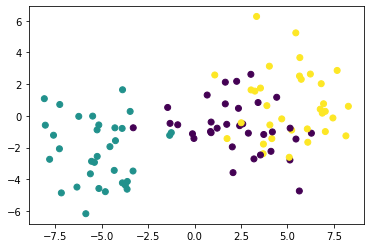

In [58]:
# plotting true clustering
plt.scatter(small_xy['X0'], small_xy['X1'], c=small_xy['y'])

TESTING FOR K = 2
. . . . . . . . FINISHED
CLUSTER SSE IS: [164.8481509346697, 106.23795040890224]
TOTAL SSE IS: 271.086101343572
TOTAL SSB IS: 419.48775684495286
SSE RATIO: 0.392551930730002

TESTING FOR K = 3
. . . . . . . . . . . FINISHED
CLUSTER SSE IS: [54.57534880918054, 154.5614535228581, 40.958751592167346]
TOTAL SSE IS: 250.09555392420594
TOTAL SSB IS: 426.4828493422974
SSE RATIO: 0.369647557055843


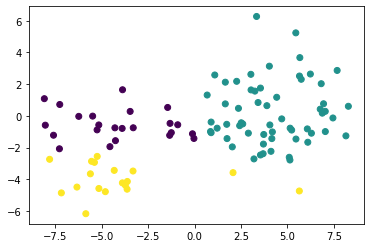

CROSS TABULATION MATRIX
	| c0	| c1	| c2	| predicted
c0	| 6	| 26	| 2	
c1	| 17	| 0	| 16	
c2	| 0	| 33	| 0	
actual


TESTING FOR K = 4
. . . . FINISHED
CLUSTER SSE IS: [23.197524969970992, 73.13475098838715, 46.08238685846334, 64.02189607492484]
TOTAL SSE IS: 206.4365588917464
TOTAL SSB IS: 449.7294385651703
SSE RATIO: 0.31461026583490537



In [59]:
# Testing on small dataset
k_collection = [2, 3, 4]
test_Kmeans_small_large(small_xy, k_collection, 3)

### Observations

To make observations and further evaluate the model I'll use a Scree plot. The Scree plot is the relationship between [cluster see / (cluster sse + cluster ssb)] and k. To pick the best k value, the technique is to look for an elbow in the graph. An elbow is a spot where the rate of decrease changes from a sharp drop to a more shallow one. The elbow's interpretation is the k value such that we stop seeing benefit from a true clustering and start seeing the benefit of overfitting.

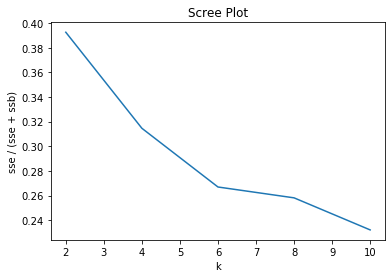

In [60]:
k_collection = [x for x in range(2, 12, 2)]
Eval_Kmeans_scree(small_xy, k_collection)

There's a pretty clear elbow here at k = 6. That's probably the best clustering. I'll plot the clustering below along with relevant statistics.

TESTING FOR K = 6
. . . . . . . . . . . . FINISHED
CLUSTER SSE IS: [14.321048894655888, 23.197524969970992, 27.786510770471924, 19.443766260326196, 25.22911100567976, 47.97577893804139]
TOTAL SSE IS: 157.95374083914618
TOTAL SSB IS: 433.7257603360633
SSE RATIO: 0.26695827813100553


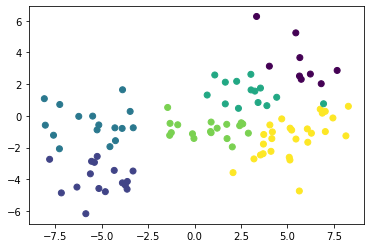

CROSS TABULATION MATRIX
	| c0	| c1	| c2	| c3	| c4	| c5	| predicted
c0	| 0	| 0	| 1	| 8	| 14	| 11	
c1	| 0	| 16	| 15	| 0	| 2	| 0	
c2	| 9	| 0	| 0	| 6	| 2	| 16	
actual




In [61]:
k_collection = [6]
test_Kmeans_small_large(small_xy, k_collection, 6)

# Testing on large dataset

In [62]:
# Calculating true cluster SSE
print('TRUE ', end='')
sse = cluster_sse(large_xy)

TRUE CLUSTER SSE IS: [421.99155838595124, 417.97861249925955, 409.1837378805536, 405.2943715217907, 413.05192212638167, 413.43120761101585]


In [63]:
# Calculating total SSE
print('TRUE ', end='')
sse = total_sse(large_xy)

TRUE TOTAL SSE IS: 2480.931410024948


In [64]:
# Calculating true cluster SSB
print('TRUE ', end='')
ssb = cluster_ssb(large_xy)

TRUE TOTAL SSB IS: 3827.0851612119227


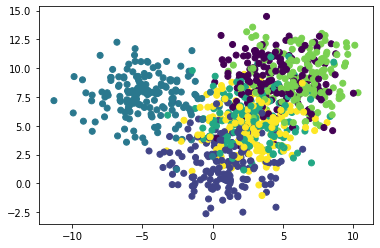

In [65]:
# plotting true clustering
plt.scatter(large_xy['X0'], large_xy['X1'], c=large_xy['y'])

TESTING FOR K = 4
. . . . . . . . . . . . . . FINISHED
CLUSTER SSE IS: [662.0238124444755, 549.0543932592994, 389.12173771755505, 656.2668969006731]
TOTAL SSE IS: 2256.466840322003
TOTAL SSB IS: 3980.4496480032612
SSE RATIO: 0.36179205614598653

TESTING FOR K = 6
. . . . . . . . . . . . . . . . . . . . . . . . . . . . FINISHED
CLUSTER SSE IS: [579.188632090293, 493.46748164048296, 154.39356837014782, 235.38062968761048, 389.8487590045081, 161.37862647954424]
TOTAL SSE IS: 2013.657697272587
TOTAL SSB IS: 4044.51380406448
SSE RATIO: 0.3323870406818565


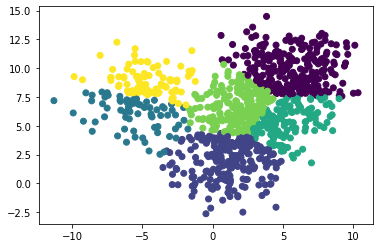

CROSS TABULATION MATRIX
	| c0	| c1	| c2	| c3	| c4	| c5	| predicted
c0	| 110	| 2	| 0	| 19	| 36	| 0	
c1	| 0	| 139	| 5	| 4	| 18	| 1	
c2	| 0	| 4	| 66	| 0	| 10	| 87	
c3	| 14	| 27	| 1	| 43	| 81	| 1	
c4	| 130	| 0	| 0	| 25	| 11	| 0	
c5	| 3	| 55	| 1	| 42	| 65	| 0	
actual


TESTING FOR K = 8
. . . . . . . . . . . . . . . . . . . . . . . . . FINISHED
CLUSTER SSE IS: [237.207598635513, 254.20353462645053, 137.5729942956823, 140.80550361705124, 229.91179902879705, 240.3320365665067, 226.5728084519693, 226.64691317212413]
TOTAL SSE IS: 1693.2531883940935
TOTAL SSB IS: 4294.345161002776
SSE RATIO: 0.28279338218547256



In [66]:
# Testing on large dataset
k_collection = [4, 6, 8]
test_Kmeans_small_large(large_xy, k_collection, 6)

### Observations

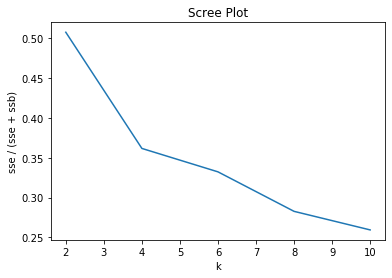

In [67]:
k_collection = [x for x in range(2, 12, 2)]
Eval_Kmeans_scree(large_xy, k_collection)

It appears the elbow of the Scree plot is at k = 4. That's probably the best clustering. The rate of decrease in sse / (sse + ssb) is less so with greater k and appear to remain somewhat constant. I'll plot the clustering below along with relevant statistics.

TESTING FOR K = 4
. . . . . . . . . . . . . . FINISHED
CLUSTER SSE IS: [662.0238124444755, 549.0543932592994, 389.12173771755505, 656.2668969006731]
TOTAL SSE IS: 2256.466840322003
TOTAL SSB IS: 3980.4496480032612
SSE RATIO: 0.36179205614598653


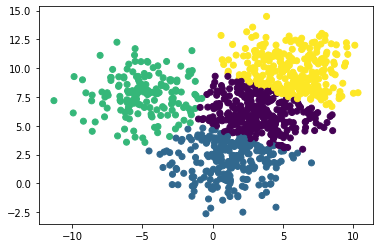

CROSS TABULATION MATRIX
	| c0	| c1	| c2	| c3	| predicted
c0	| 44	| 2	| 0	| 121	
c1	| 21	| 143	| 3	| 0	
c2	| 3	| 5	| 159	| 0	
c3	| 114	| 33	| 3	| 17	
c4	| 28	| 0	| 0	| 138	
c5	| 106	| 56	| 1	| 3	
actual




In [68]:
k_collection = [4]
test_Kmeans_small_large(large_xy, k_collection, 4)

# Testing on wine dataset

In [69]:
# Calculating true cluster SSE
print('TRUE ', end='')
red_wine_no_qual = red_wine.drop(columns=['quality'])
sse = cluster_sse(red_wine_no_qual)

TRUE CLUSTER SSE IS: [171.09420104053928, 1278.190682953005, 22473.498326440054, 14049.63197832256, 4410.547058000449, 408.6992957298975]


In [70]:
# Calculating total SSE
print('TRUE ', end='')
sse = total_sse(red_wine_no_qual)

TRUE TOTAL SSE IS: 42791.66154248646


In [71]:
# Calculating true cluster SSB
print('TRUE ', end='')
ssb = cluster_ssb(red_wine_no_qual)

TRUE TOTAL SSB IS: 13826.117348139604


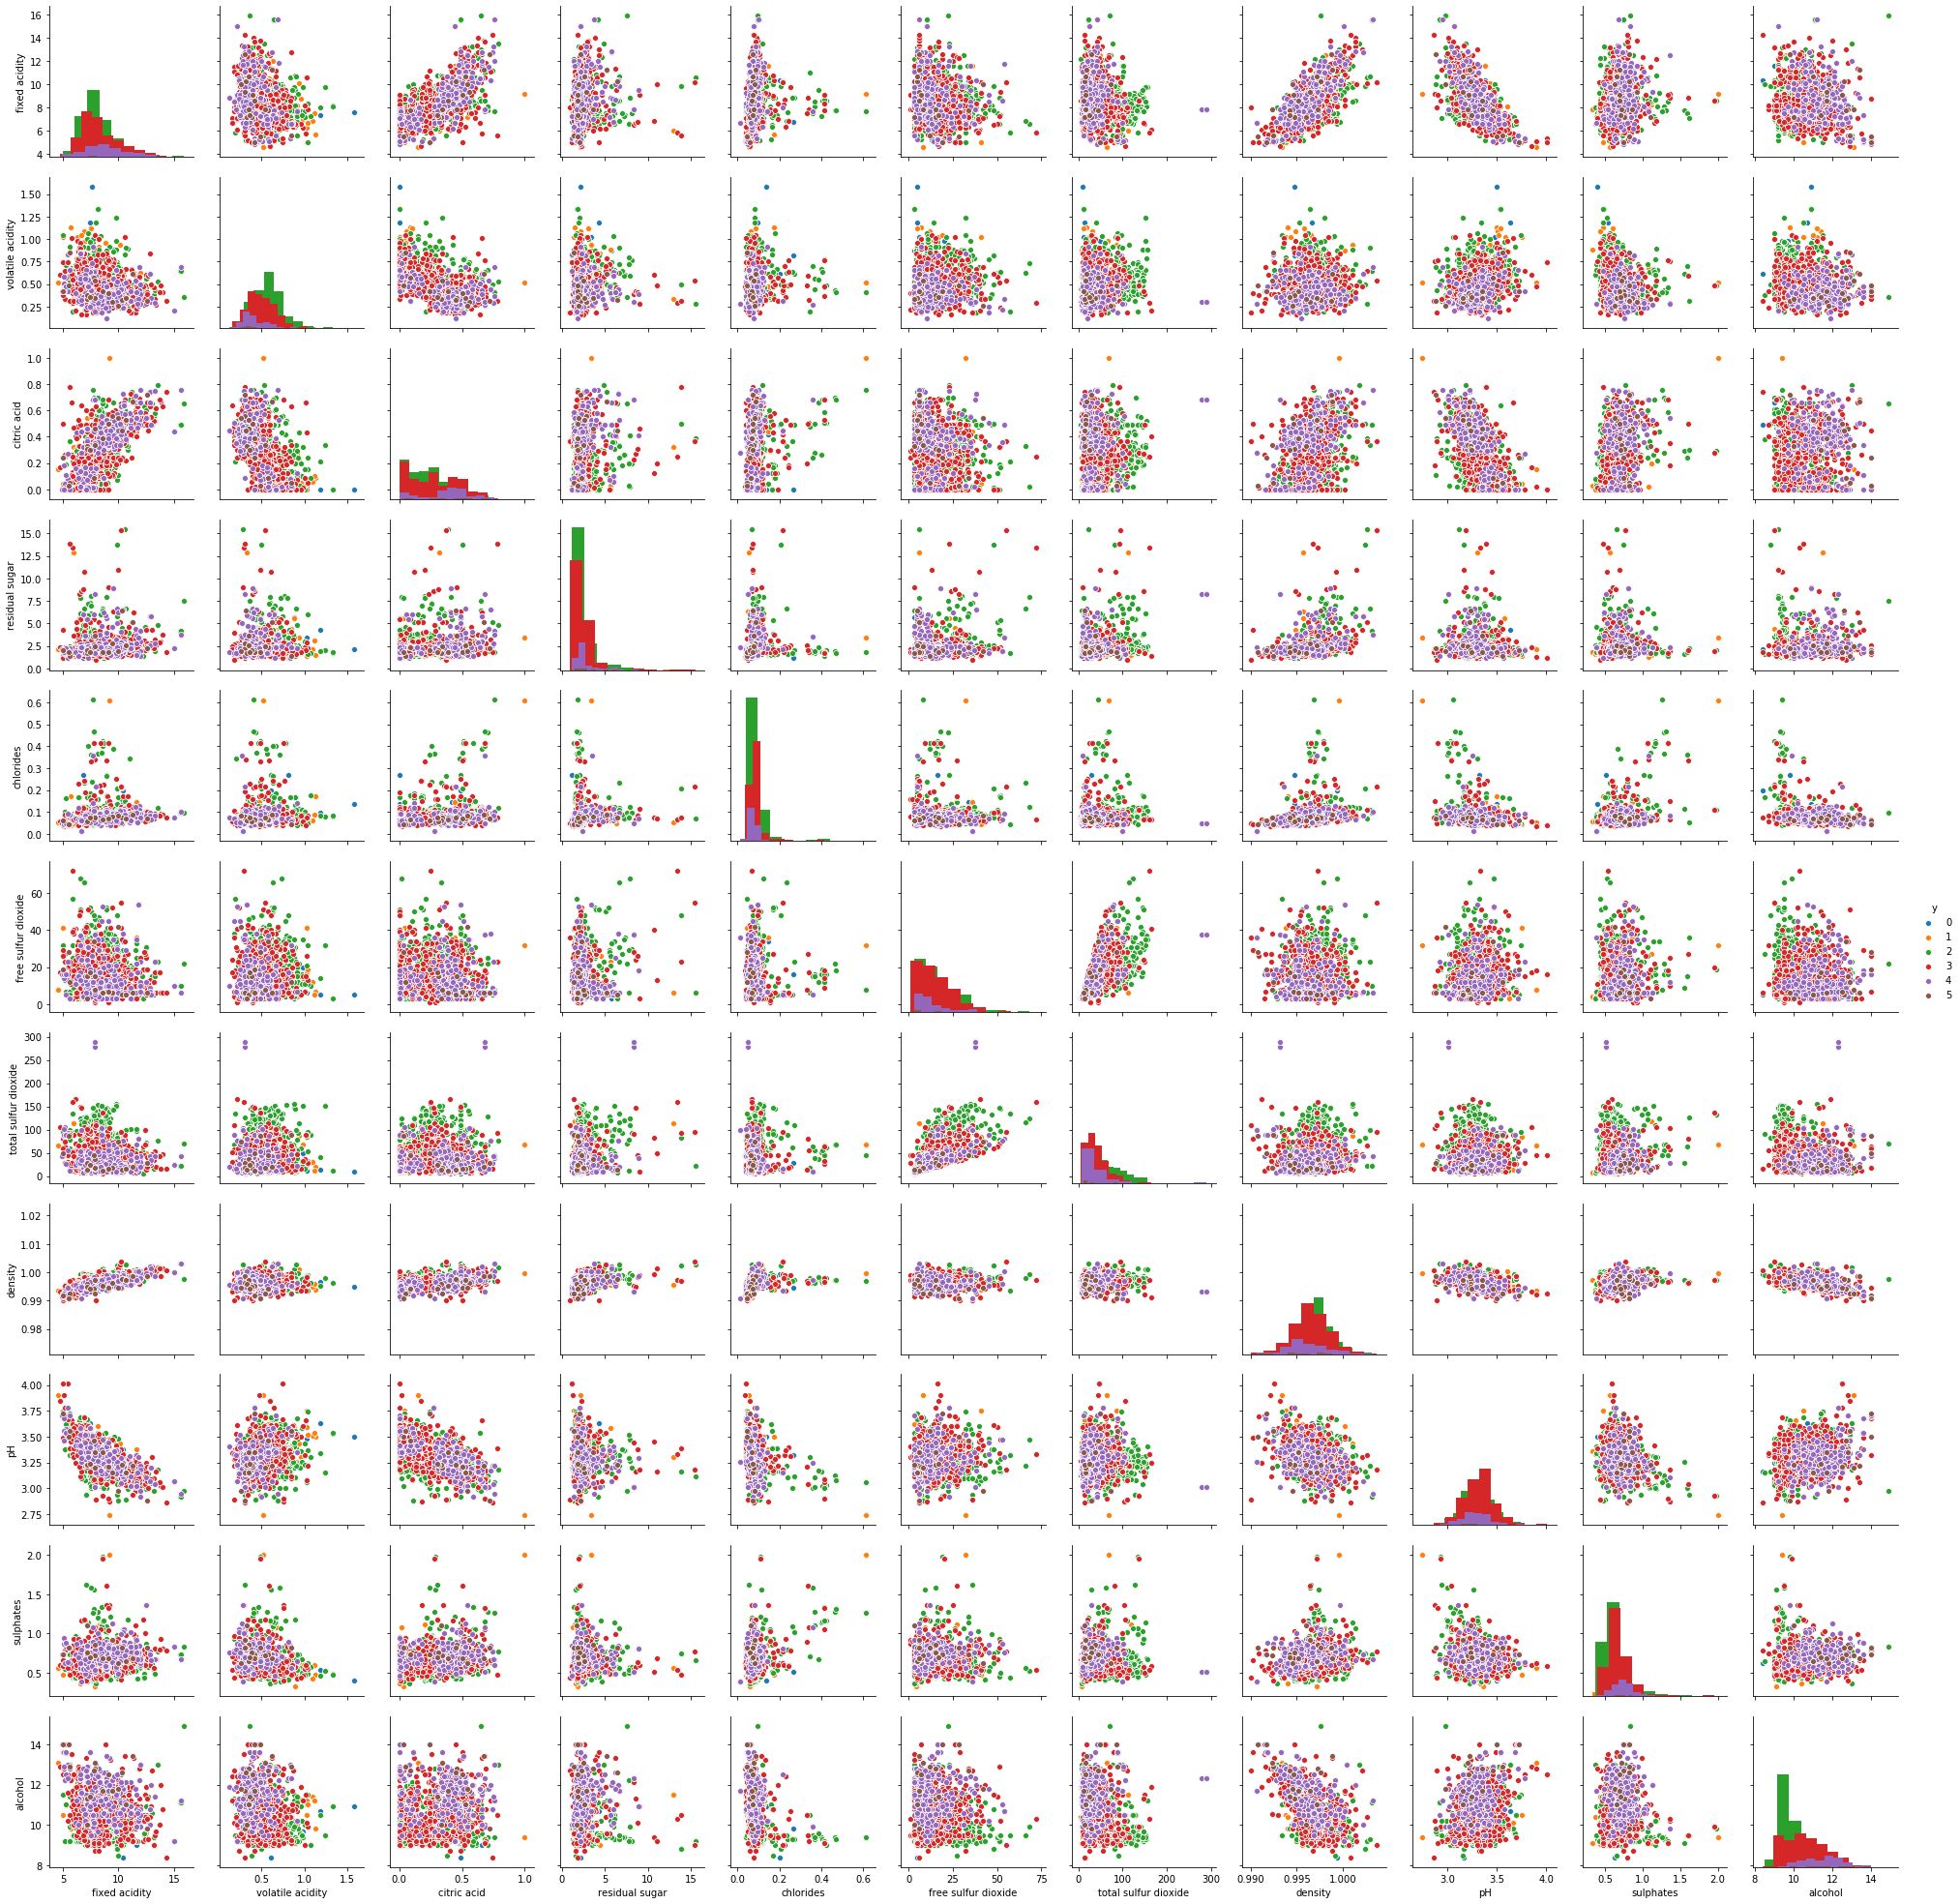

In [72]:
# plotting true clustering
sb.pairplot(red_wine_no_qual, 
            hue='y', 
            vars=red_wine_no_qual.columns[:-1],
            diag_kind = 'hist')

In [73]:
# Testing on wine dataset, had to split them out of the loop to get
# the seaborn plot to show in proper order. It takes a while to load.

In [74]:
test_Kmeans_redwine(red_wine, 4)

TESTING FOR K = 4
. . . . . . . . . . . . . . FINISHED
CLUSTER SSE IS: [27092.44449275976, 754.7434313077567, 11178.995006390533, 1943.5692461620743]
TOTAL SSE IS: 40969.7521766202
TOTAL SSB IS: 13015.807880637243
SSE RATIO: 0.7589020496067357



TESTING FOR K = 6
. . . . . . . . . . . . . . . . . . . . FINISHED
CLUSTER SSE IS: [10888.685381436475, 1496.5269048973569, 10536.206011510541, 34.022488281135466, 6280.87021648497, 749.2728542794449]
TOTAL SSE IS: 29985.58385688987
TOTAL SSB IS: 35692.36077359333
SSE RATIO: 0.456554845398932
CROSS TABULATION MATRIX
	| c0	| c1	| c2	| c3	| c4	| c5	| predicted
c0	| 7	| 0	| 1	| 0	| 2	| 0	
c1	| 36	| 1	| 8	| 1	| 7	| 0	
c2	| 284	| 16	| 248	| 1	| 114	| 18	
c3	| 283	| 12	| 126	| 0	| 208	| 9	
c4	| 54	| 5	| 21	| 0	| 118	| 1	
c5	| 7	| 0	| 1	| 0	| 10	| 0	
actual




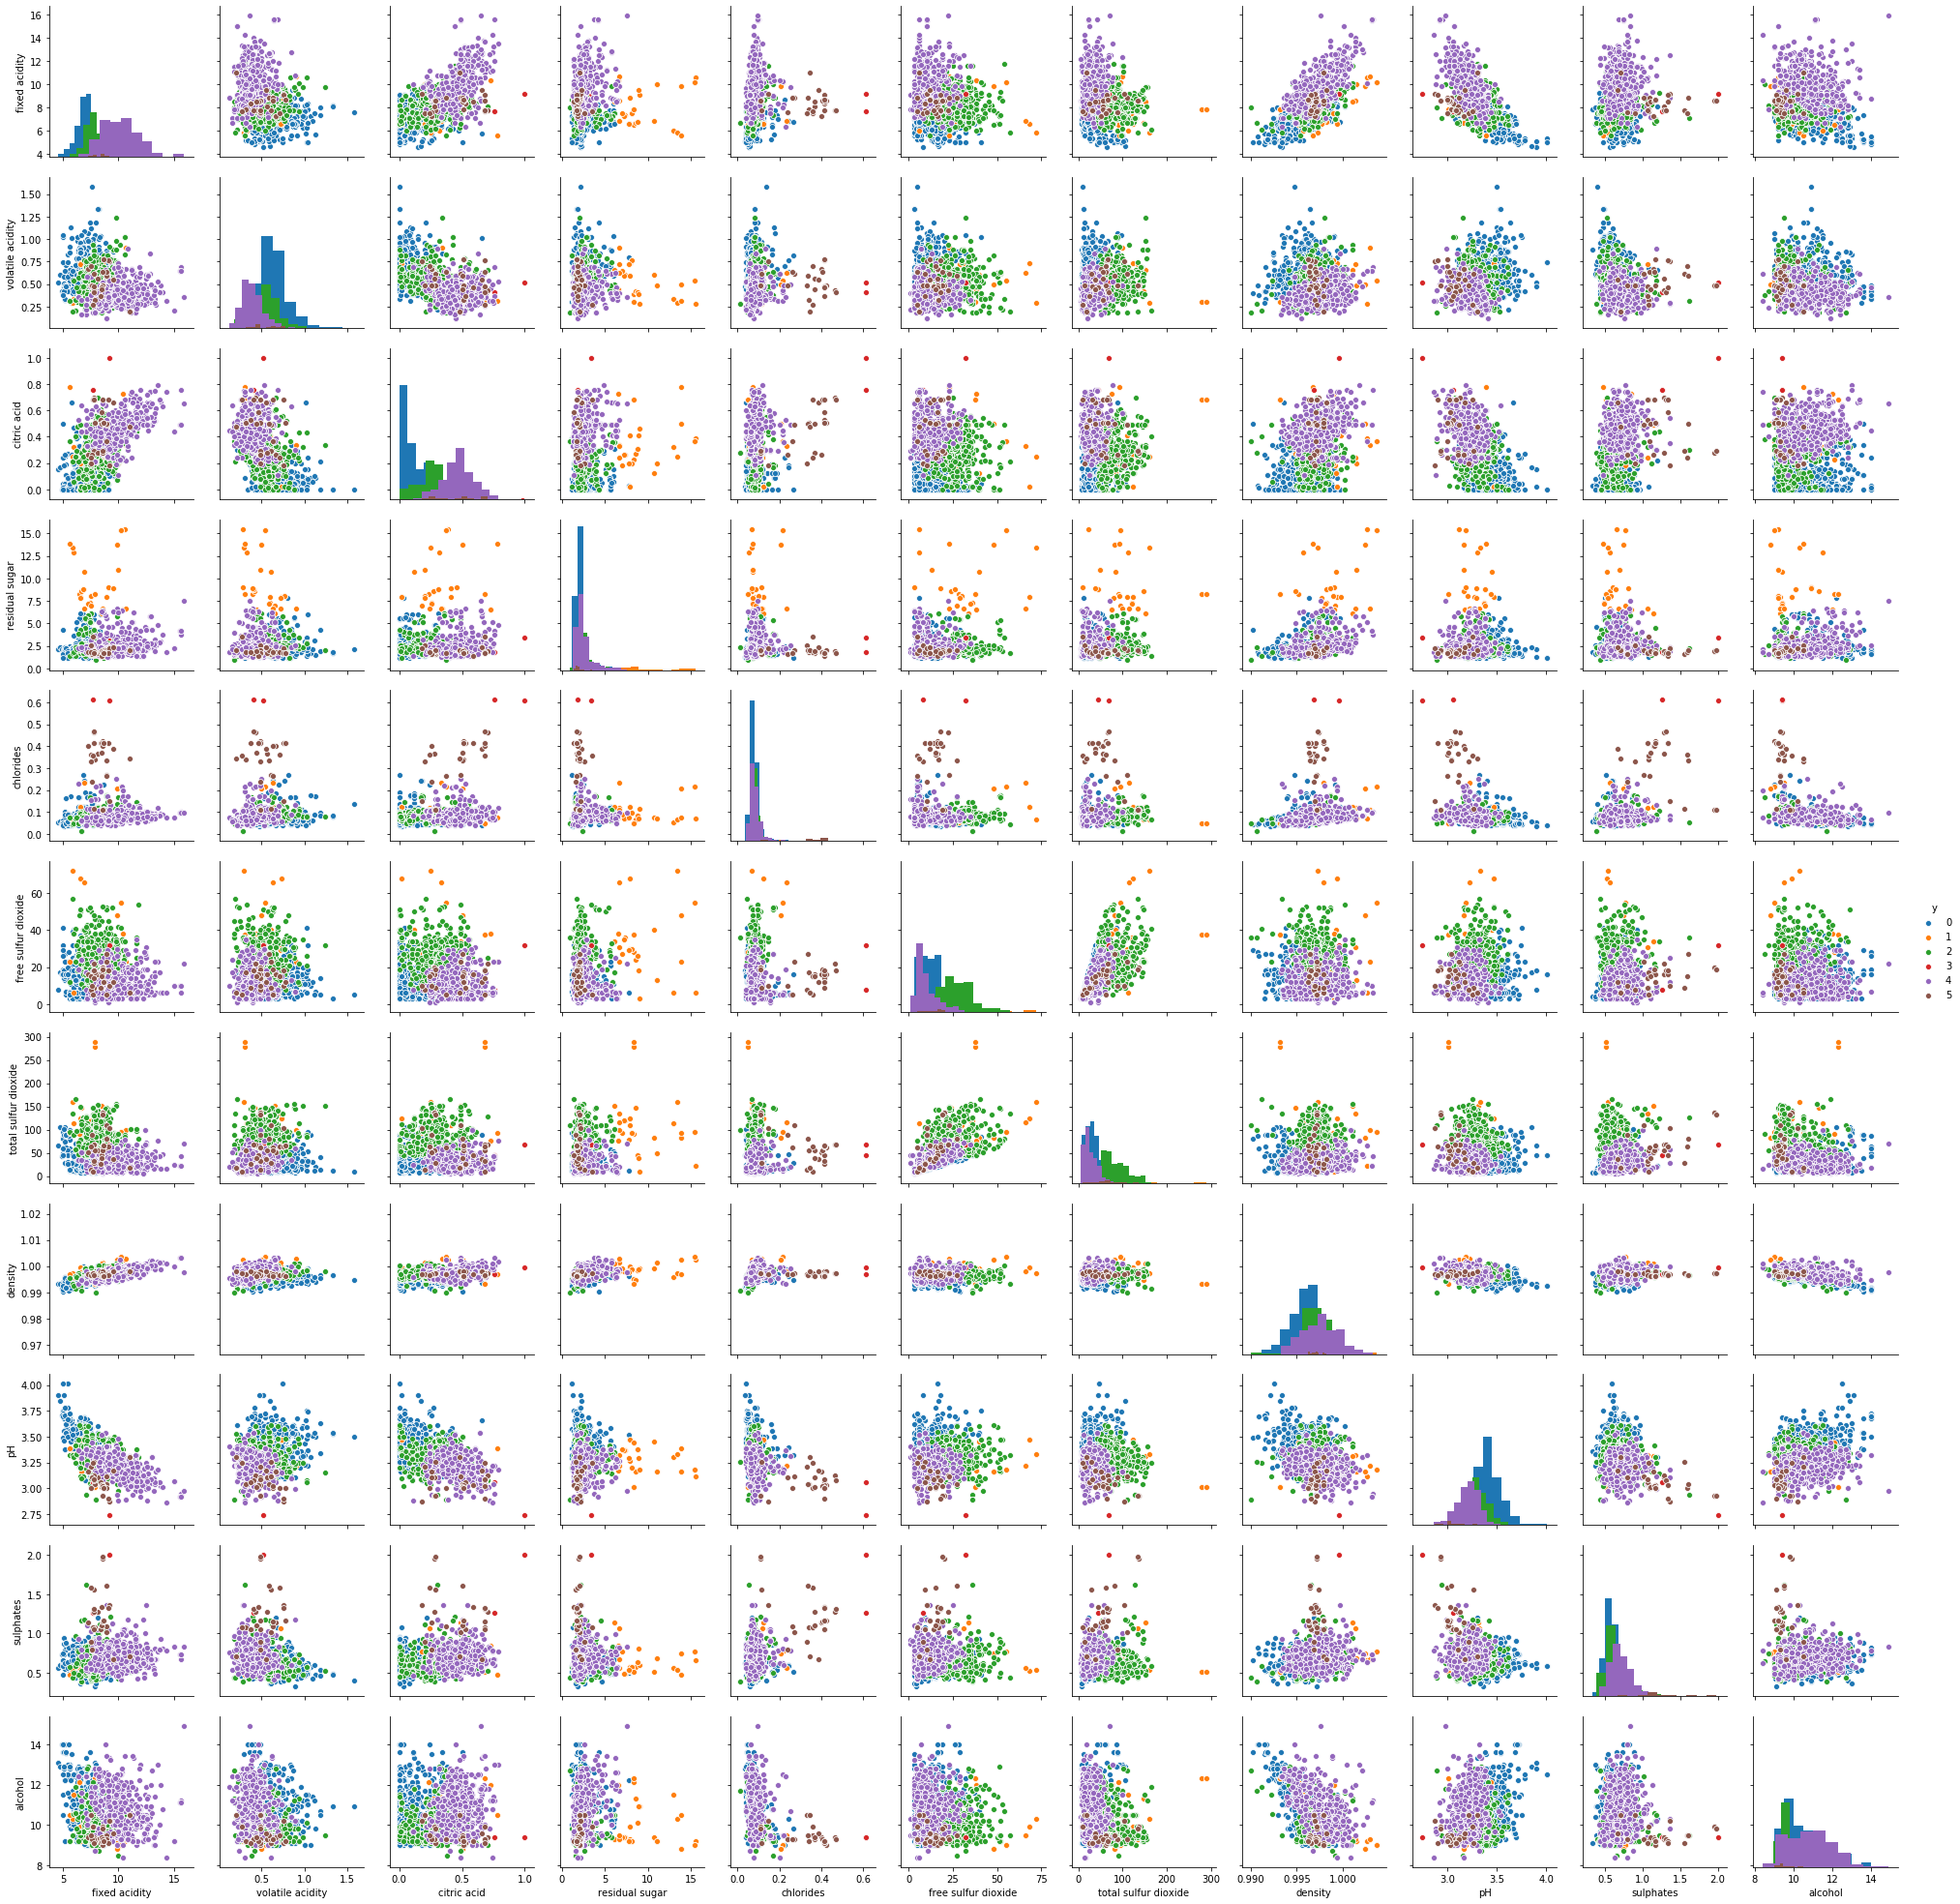

In [75]:
test_Kmeans_redwine(red_wine, 6, 6)

In [76]:
test_Kmeans_redwine(red_wine, 8)

TESTING FOR K = 8
. . . . . . . . . . . . . . . . . . . FINISHED
CLUSTER SSE IS: [4158.527352294345, 4139.034726171384, 7419.556838875911, 4071.6172647002713, 8632.030854297584, 749.2728542794449, 34.022488281135466, 1496.5269048973569]
TOTAL SSE IS: 30700.589283797482
TOTAL SSB IS: 33498.89556630435
SSE RATIO: 0.4782061624868129



### Observations

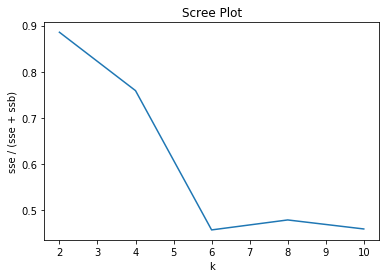

In [77]:
k_collection = [x for x in range(2, 12, 2)]
Eval_Kmeans_scree(red_wine.drop(columns=['quality']), k_collection)

It appears the elbow of the Scree plot is at k = 6. That's likely the best clustering. I won't replot the clustering.

# Comparing with Sklearn K-means

In [78]:
from sklearn import cluster as cl # for testing K-means

In [79]:
def Eval_SKLearn_Kmeans_scree(data, k_collection):
    x = data.drop(columns=['y'])
    scores = [0 for i in k_collection]
    for index, k in enumerate(k_collection):
        kmeans = cl.KMeans(n_clusters = k)
        x['y'] = kmeans.fit_predict(x)
        # Calculating test SSE, SSB
        sse = total_sse(x, False)
        ssb = cluster_ssb(x, False)
        scores[index] = (k, sse / (sse + ssb))
        x = x.drop(columns=['y'])
    plt.plot(*zip(*scores))
    plt.title("Scree Plot")
    plt.ylabel("sse / (sse + ssb)")
    plt.xlabel("k")
    plt.show()

In [80]:
def test_SKLearn_Kmeans_small_large(data, k_collection, k_special = 0):
    x = data.drop(columns=['y'])
    for k in k_collection:
        kmeans = cl.KMeans(n_clusters = k)
        x['y'] = kmeans.fit_predict(x)
        # Calculating test SSE, SSB
        cluster_sse(x)
        sse = total_sse(x)
        ssb = cluster_ssb(x)
        print(f'SSE RATIO: {sse / (sse + ssb)}')
        if k == k_special:
            plt.scatter(x['X0'], x['X1'], c=x['y'])
            plt.show()
            cross_tab(data['y'], x['y'])
        x = x.drop(columns=['y'])
        print()

In [81]:
def test_SKLearn_Kmeans_redwine(data, k, k_special = 0):
    x = data.drop(columns=['quality', 'y'])
    kmeans = cl.KMeans(n_clusters = k)
    x['y'] = kmeans.fit_predict(x)
    # Calculating test SSE, SSB
    cluster_sse(x)
    sse = total_sse(x)
    ssb = cluster_ssb(x)
    print(f'SSE RATIO: {sse / (sse + ssb)}')
    if k == k_special:
        sb.pairplot(x, 
                    vars=x.loc[:, x.columns != 'y'], 
                    hue ='y',
                    diag_kind = 'hist')
        cross_tab(data['y'], x['y'])
    x = x.drop(columns=['y'])
    print()

## Evaluating on small data set

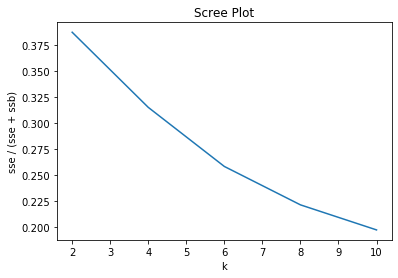

In [82]:
k_collection = [x for x in range(2, 12, 2)]
Eval_SKLearn_Kmeans_scree(small_xy, k_collection)

The Scree plot here is pretty radically different than the one I produced with my kmeans algorithm. It shows near constant decrease until a k value of 6 where it starts to level off. That's still the same k value I chose in our previous rounds of testing. I'll plot the k = 6 clustering below.

CLUSTER SSE IS: [25.113650316705517, 27.786510770471924, 28.88352039998379, 29.171406839346304, 23.197524969970992, 16.210872383529896]
TOTAL SSE IS: 150.36348568000844
TOTAL SSB IS: 434.4472418710884
SSE RATIO: 0.2571147870519709


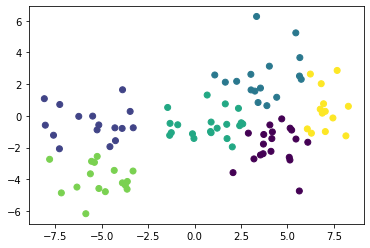

CROSS TABULATION MATRIX
	| c0	| c1	| c2	| c3	| c4	| c5	| predicted
c0	| 11	| 1	| 5	| 16	| 0	| 1	
c1	| 0	| 15	| 0	| 2	| 16	| 0	
c2	| 8	| 0	| 11	| 2	| 0	| 12	
actual




In [83]:
test_SKLearn_Kmeans_small_large(small_xy, [6], k_special = 6)

## Evaluating on large data set

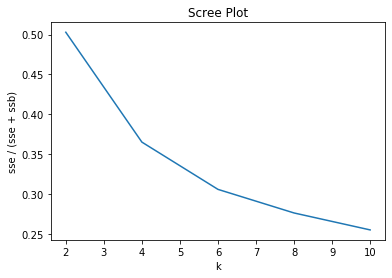

In [84]:
k_collection = [x for x in range(2, 12, 2)]
Eval_SKLearn_Kmeans_scree(large_xy, k_collection)

The elbow here appears at 4. It's more apparent than on the small data set. K = 4 is again, the same as the k value I chose before. I'll plot the clustering below.

CLUSTER SSE IS: [537.5157636165864, 666.3510261776227, 390.04468936603956, 646.4919803291158]
TOTAL SSE IS: 2240.403459489365
TOTAL SSB IS: 3891.086218694983
SSE RATIO: 0.36539300840065864


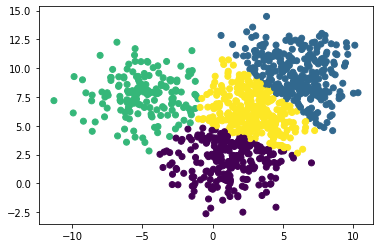

CROSS TABULATION MATRIX
	| c0	| c1	| c2	| c3	| predicted
c0	| 2	| 113	| 0	| 52	
c1	| 143	| 0	| 4	| 20	
c2	| 5	| 0	| 158	| 4	
c3	| 32	| 17	| 3	| 115	
c4	| 0	| 146	| 0	| 20	
c5	| 55	| 5	| 1	| 105	
actual




In [85]:
test_SKLearn_Kmeans_small_large(large_xy, [4], k_special = 4)

## Evaluating on Red Wine data set

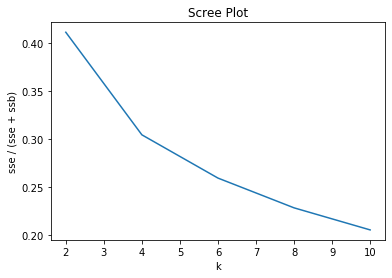

In [86]:
k_collection = [x for x in range(2, 12, 2)]
Eval_SKLearn_Kmeans_scree(red_wine.drop(columns=['quality']), k_collection)

There are two possible elbows in this graph that could be considered ideal. The first is at 4 and the second at 6. I'll choose the one at 6 because after the k = 6 value the rate of decrease remains nearly constant from 6 - 10. K = 6 is also the same k value I chose as ideal from the previous round of testing.

CLUSTER SSE IS: [2471.767864327411, 3994.8735714567297, 3783.6483217172804, 11.0, 1116.7179271251641, 3297.3475044500997]
TOTAL SSE IS: 14675.35518907669
TOTAL SSB IS: 41888.52501338517
SSE RATIO: 0.25944746252464423
CROSS TABULATION MATRIX
	| c0	| c1	| c2	| c3	| c4	| c5	| predicted
c0	| 0	| 6	| 3	| 0	| 0	| 1	
c1	| 4	| 28	| 10	| 0	| 1	| 10	
c2	| 116	| 199	| 166	| 0	| 66	| 134	
c3	| 54	| 244	| 210	| 0	| 6	| 124	
c4	| 12	| 110	| 55	| 2	| 0	| 20	
c5	| 2	| 11	| 3	| 0	| 0	| 2	
actual




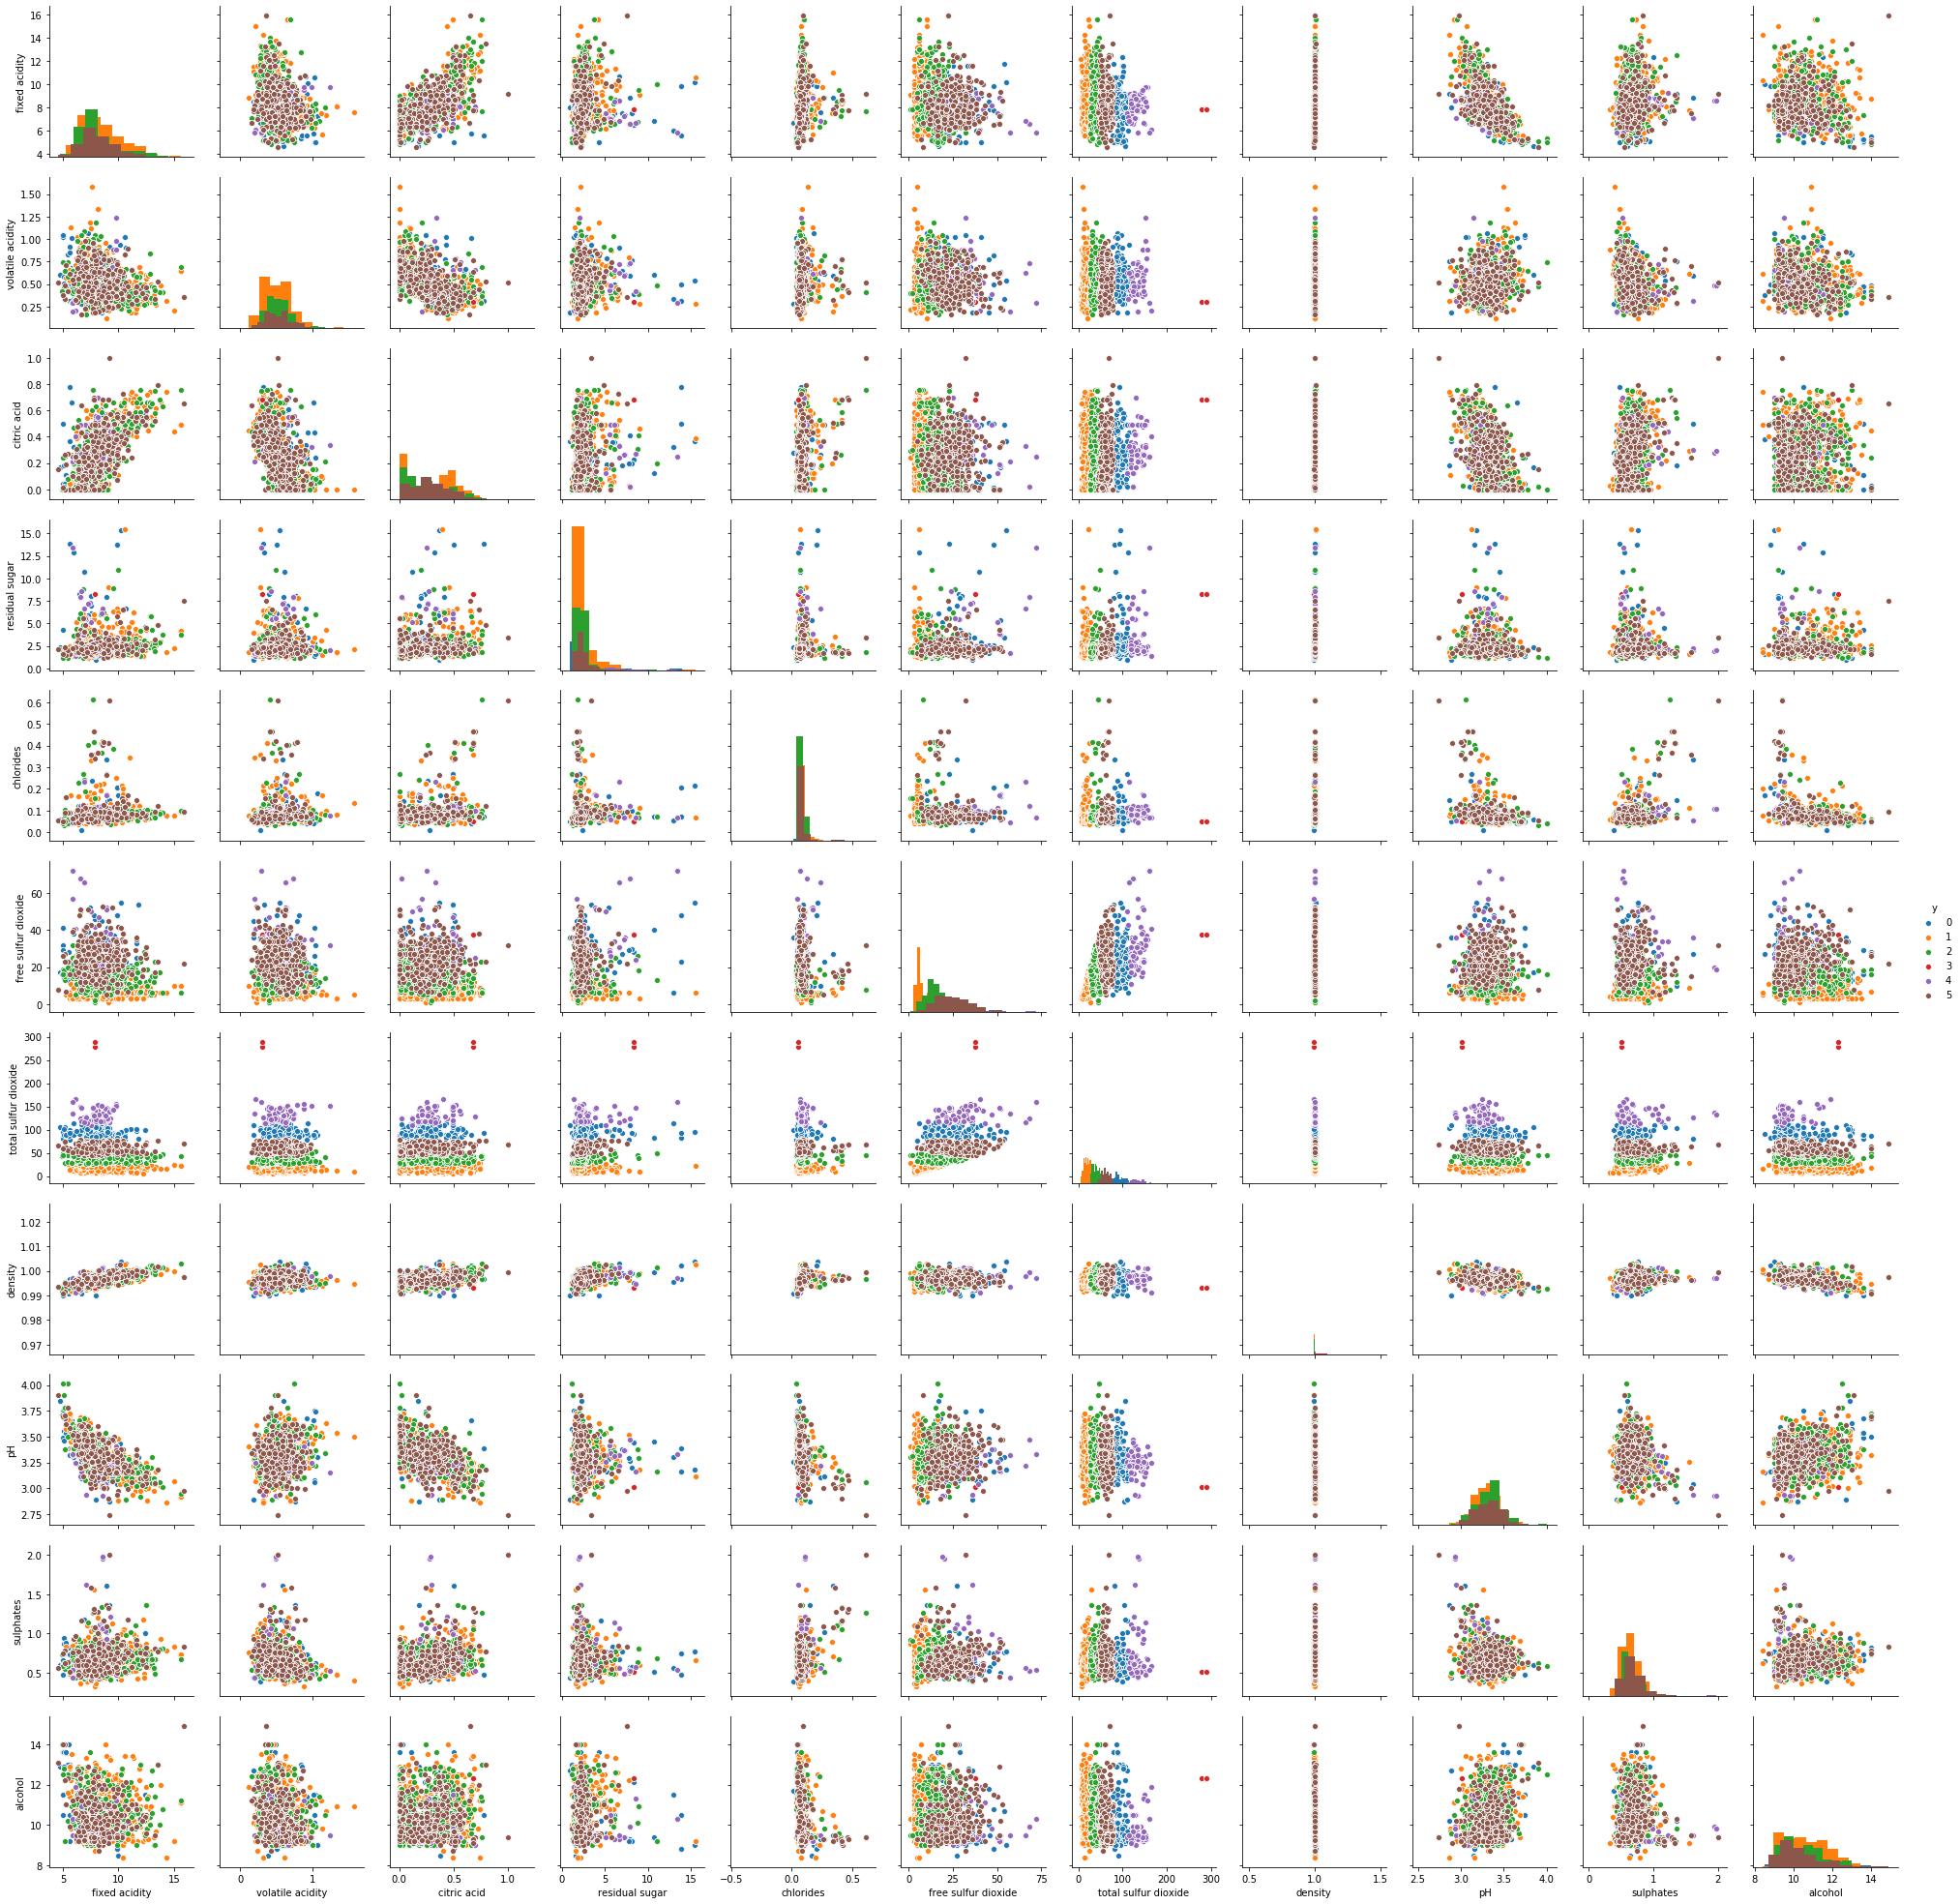

In [87]:
test_SKLearn_Kmeans_redwine(red_wine, 6, k_special = 6)

# Comparing with two other clustering algorithms

## Gaussian Mixture Model Clustering

From sklearn:

    A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. One can think of mixture models as generalizing k-means clustering to incorporate information about the covariance structure of the data as well as the centers of the latent Gaussians.

In [88]:
from sklearn.mixture import GaussianMixture as GMM

In [89]:
def Eval_SKLearn_GMM_scree(data, k_collection):
    x = data.drop(columns=['y'])
    scores = [0 for i in k_collection]
    for index, k in enumerate(k_collection):
        gmm = GMM(n_components = k)
        x['y'] = gmm.fit_predict(x)
        # Calculating test SSE, SSB
        sse = total_sse(x, False)
        ssb = cluster_ssb(x, False)
        scores[index] = (k, sse / (sse + ssb))
        x = x.drop(columns=['y'])
    plt.plot(*zip(*scores))
    plt.title("Scree Plot")
    plt.ylabel("sse / (sse + ssb)")
    plt.xlabel("k")
    plt.show()

In [90]:
def test_SKLearn_GMM_small_large(data, k_collection, k_special = 0):
    x = data.drop(columns=['y'])
    for k in k_collection:
        gmm = GMM(n_components = k)
        x['y'] = gmm.fit_predict(x)
        # Calculating test SSE, SSB
        cluster_sse(x)
        sse = total_sse(x)
        ssb = cluster_ssb(x)
        print(f'SSE RATIO: {sse / (sse + ssb)}')
        if k == k_special:
            plt.scatter(x['X0'], x['X1'], c=x['y'])
            plt.show()
            cross_tab(data['y'], x['y'])
        x = x.drop(columns=['y'])
        print()

In [91]:
def test_SKLearn_GMM_redwine(data, k, k_special = 0):
    x = data.drop(columns=['quality', 'y'])
    gmm = GMM(n_components = k)
    x['y'] = gmm.fit_predict(x)
    # Calculating test SSE, SSB
    cluster_sse(x)
    sse = total_sse(x)
    ssb = cluster_ssb(x)
    print(f'SSE RATIO: {sse / (sse + ssb)}')
    if k == k_special:
        sb.pairplot(x, 
                    vars=x.loc[:, x.columns != 'y'], 
                    hue ='y',
                    diag_kind = 'hist')
        cross_tab(data['y'], x['y'])
    x = x.drop(columns=['y'])
    print()

## Evaluating on small data set

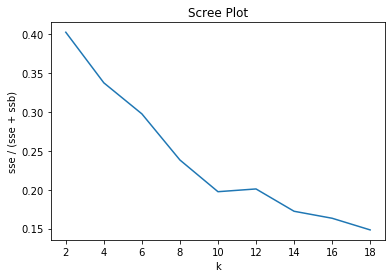

In [92]:
k_collection = [x for x in range(2, 20, 2)]
Eval_SKLearn_GMM_scree(small_xy, k_collection)

CLUSTER SSE IS: [22.259240947405164, 19.92423302517606, 29.943740736444642, 26.036592357641275, 20.790905667554412, 34.93146095209374]
TOTAL SSE IS: 153.88617368631526
TOTAL SSB IS: 438.35478003475976
SSE RATIO: 0.25983710298898094


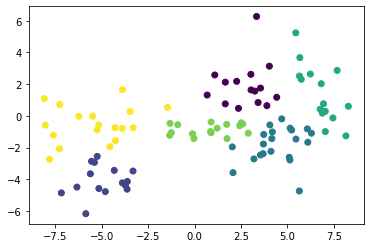

CROSS TABULATION MATRIX
	| c0	| c1	| c2	| c3	| c4	| c5	| predicted
c0	| 8	| 0	| 12	| 0	| 12	| 2	
c1	| 0	| 15	| 0	| 0	| 2	| 16	
c2	| 7	| 0	| 9	| 15	| 2	| 0	
actual




In [93]:
test_SKLearn_GMM_small_large(small_xy, [6], k_special = 6)

## Evaluating on large data set

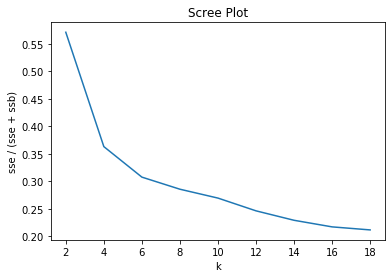

In [94]:
k_collection = [x for x in range(2, 20, 2)]
Eval_SKLearn_GMM_scree(large_xy, k_collection)

CLUSTER SSE IS: [376.6374562533373, 702.1533787373509, 544.9836781878048, 618.9660942181022]
TOTAL SSE IS: 2242.7406073965976
TOTAL SSB IS: 3938.3921164928233
SSE RATIO: 0.3628365070901396


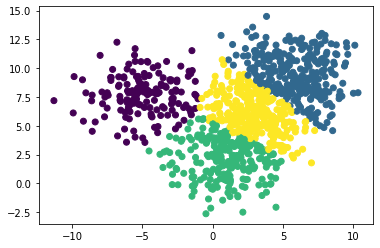

CROSS TABULATION MATRIX
	| c0	| c1	| c2	| c3	| predicted
c0	| 0	| 120	| 2	| 45	
c1	| 1	| 0	| 148	| 18	
c2	| 158	| 0	| 6	| 3	
c3	| 3	| 19	| 30	| 115	
c4	| 0	| 147	| 0	| 19	
c5	| 1	| 7	| 53	| 105	
actual




In [95]:
test_SKLearn_GMM_small_large(large_xy, [4], k_special = 4)

## Evaluating on Red Wine data set

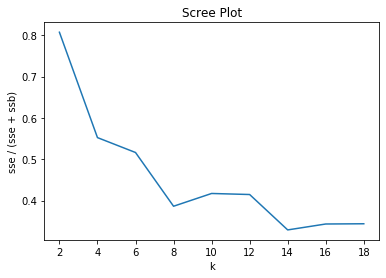

In [96]:
k_collection = [x for x in range(2, 20, 2)]
Eval_SKLearn_GMM_scree(red_wine.drop(columns=['quality']), k_collection)

CLUSTER SSE IS: [10954.087313831726, 3429.649604372425, 2638.962615217396, 1071.0795756489704, 660.6866912068739, 8562.14100201374]
TOTAL SSE IS: 27316.606802291084
TOTAL SSB IS: 39418.009047600324
SSE RATIO: 0.40933189551484517
CROSS TABULATION MATRIX
	| c0	| c1	| c2	| c3	| c4	| c5	| predicted
c0	| 0	| 0	| 2	| 0	| 5	| 3	
c1	| 8	| 7	| 5	| 1	| 7	| 25	
c2	| 251	| 50	| 61	| 15	| 29	| 275	
c3	| 164	| 50	| 24	| 9	| 46	| 345	
c4	| 27	| 19	| 1	| 2	| 36	| 114	
c5	| 2	| 3	| 0	| 0	| 4	| 9	
actual




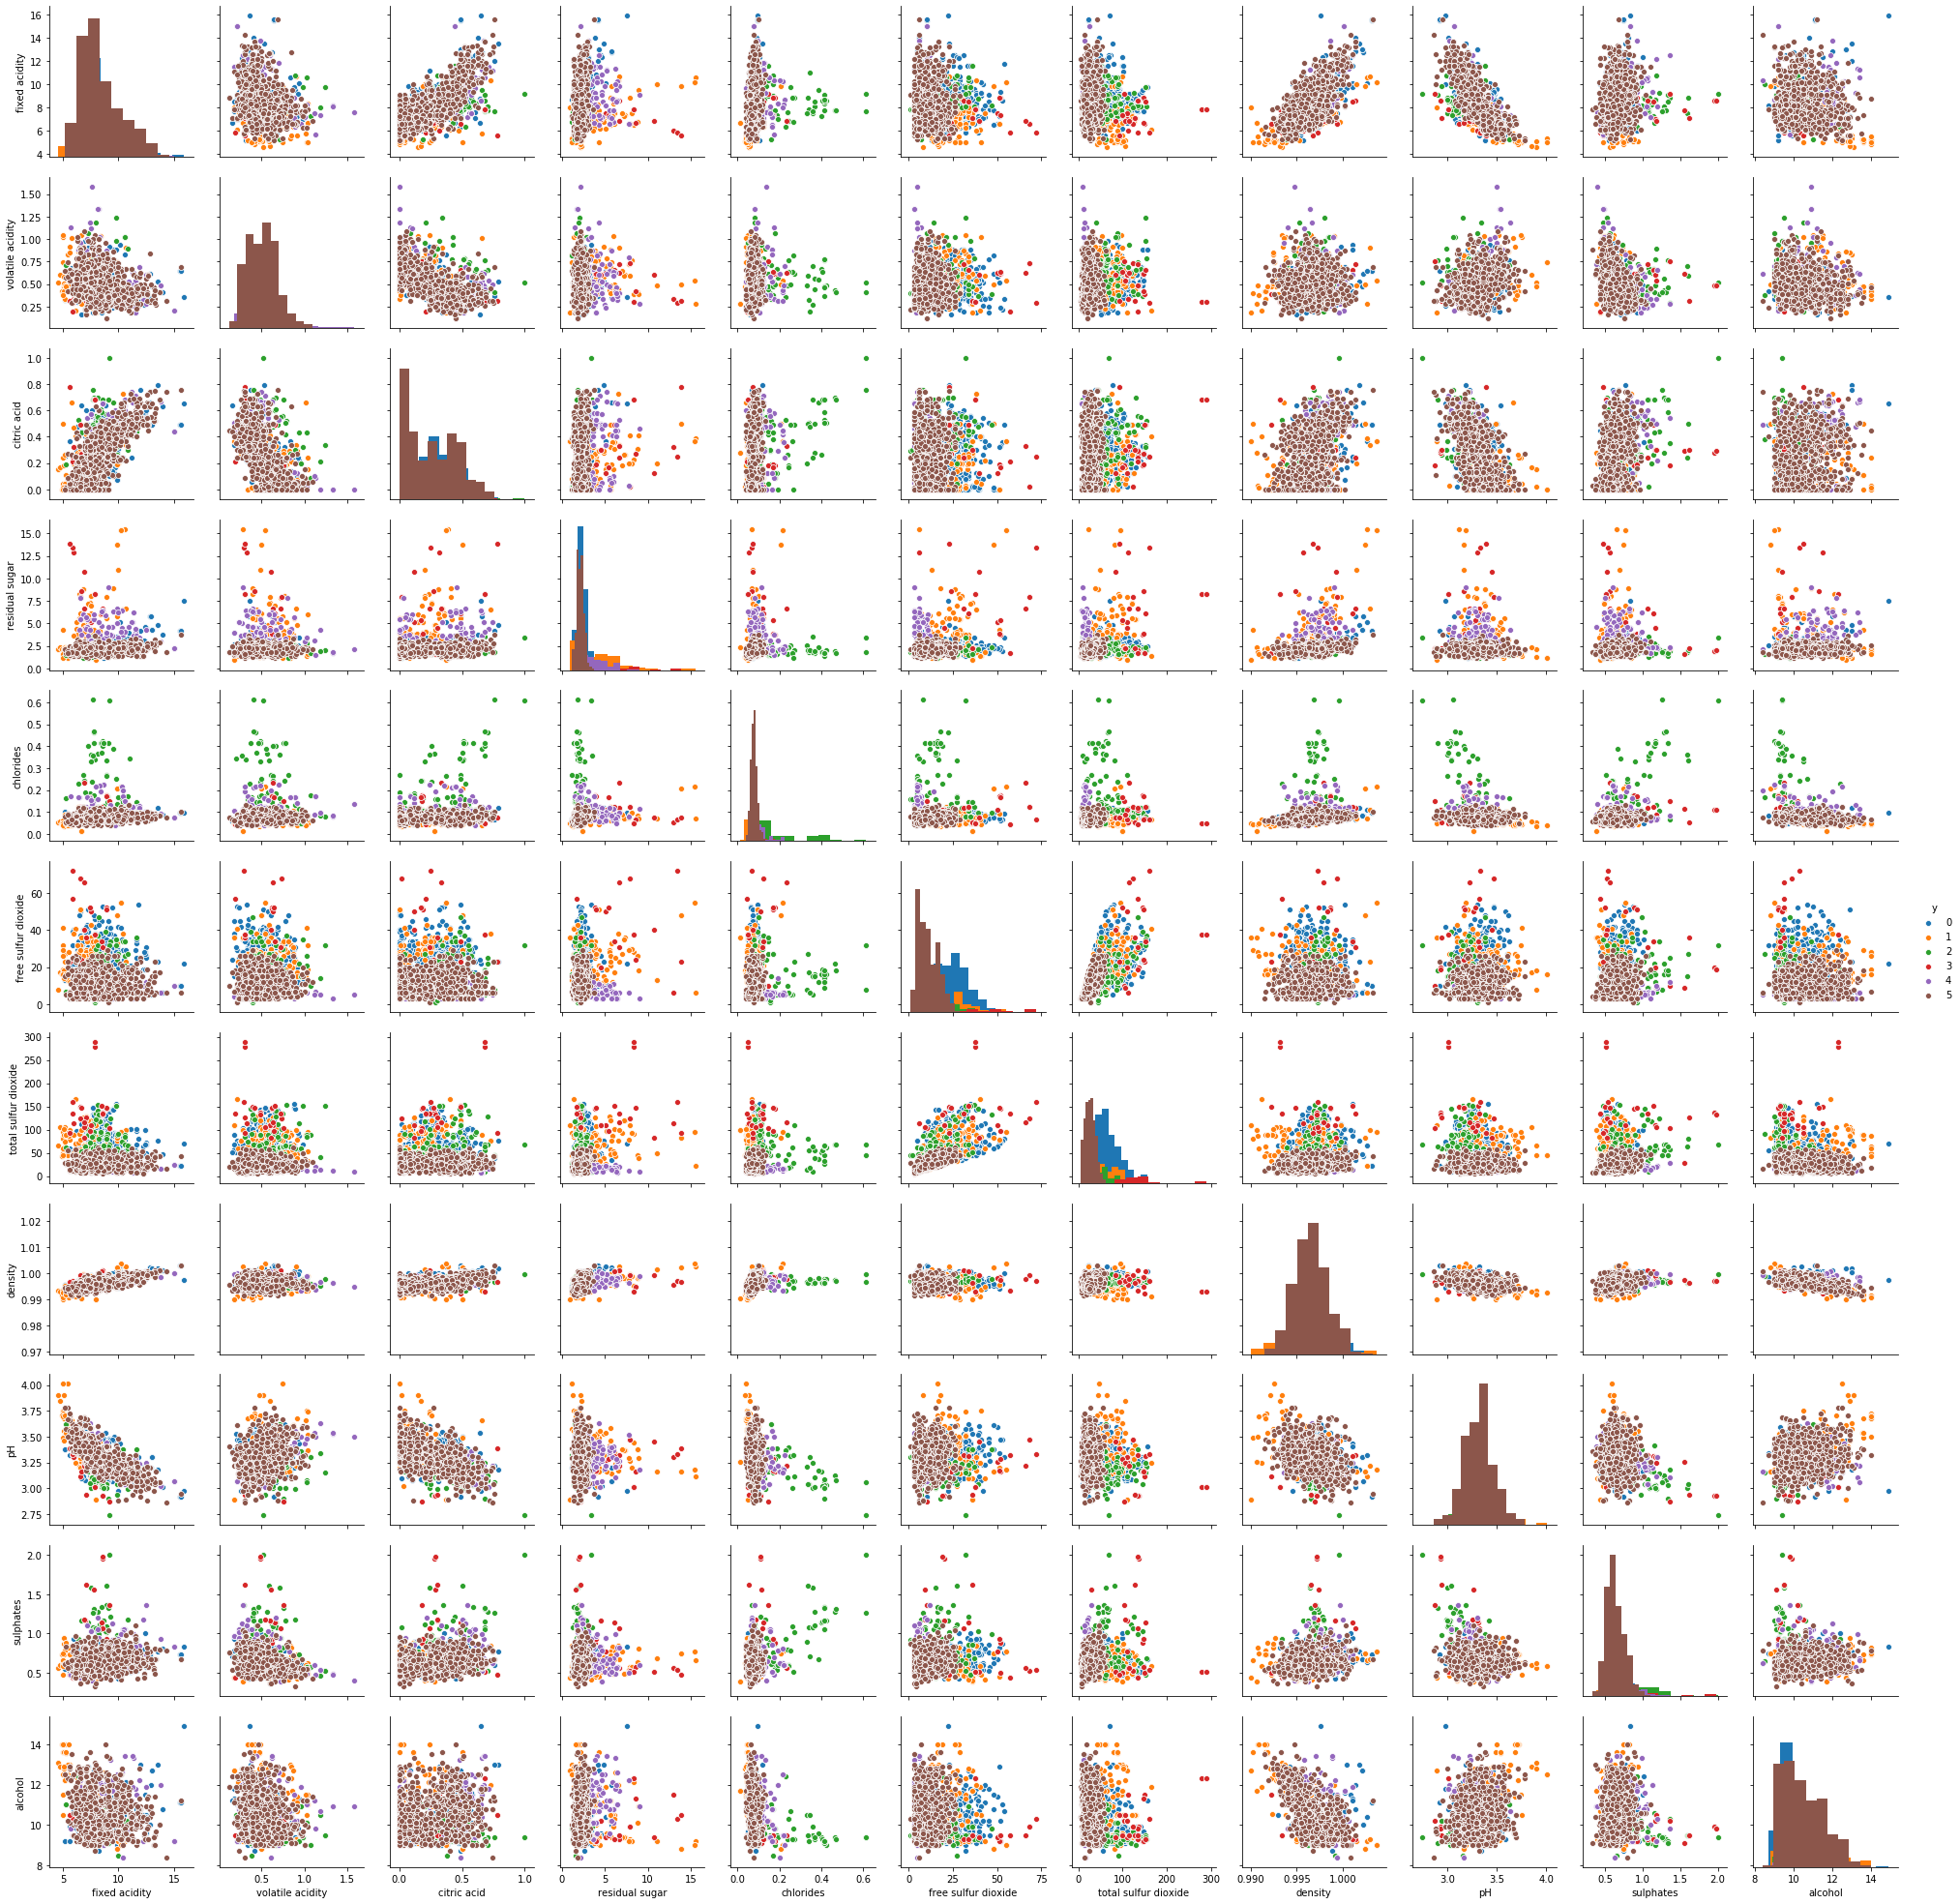

In [97]:
test_SKLearn_GMM_redwine(red_wine, 6, k_special = 6)

## Agglomerative Clustering

From sklearn:

    The AgglomerativeClustering object performs a hierarchical clustering using a bottom up approach: each observation starts in its own cluster, and clusters are successively merged together. The linkage criteria determines the metric used for the merge strategy:

    Ward minimizes the sum of squared differences within all clusters. It is a variance-minimizing approach and in this sense is similar to the k-means objective function but tackled with an agglomerative hierarchical approach.

    Maximum or complete linkage minimizes the maximum distance between observations of pairs of clusters.

    Average linkage minimizes the average of the distances between all observations of pairs of clusters.

    Single linkage minimizes the distance between the closest observations of pairs of clusters.
    
I'll be testing with the ward strategy

In [98]:
from sklearn.cluster import AgglomerativeClustering as AGG

In [99]:
def Eval_SKLearn_agg_scree(data, k_collection):
    x = data.drop(columns=['y'])
    scores = [0 for i in k_collection]
    for index, k in enumerate(k_collection):
        agg = AGG(n_clusters = k)
        x['y'] = agg.fit_predict(x)
        # Calculating test SSE, SSB
        sse = total_sse(x, False)
        ssb = cluster_ssb(x, False)
        scores[index] = (k, sse / (sse + ssb))
        x = x.drop(columns=['y'])
    plt.plot(*zip(*scores))
    plt.title("Scree Plot")
    plt.ylabel("sse / (sse + ssb)")
    plt.xlabel("k")
    plt.show()

In [100]:
def test_SKLearn_agg_small_large(data, k_collection, k_special = 0):
    x = data.drop(columns=['y'])
    for k in k_collection:
        agg = AGG(n_clusters = k)
        x['y'] = agg.fit_predict(x)
        # Calculating test SSE, SSB
        cluster_sse(x)
        sse = total_sse(x)
        ssb = cluster_ssb(x)
        print(f'SSE RATIO: {sse / (sse + ssb)}')
        if k == k_special:
            plt.scatter(x['X0'], x['X1'], c=x['y'])
            plt.show()
            cross_tab(data['y'], x['y'])
        x = x.drop(columns=['y'])
        print()

In [101]:
def test_SKLearn_agg_redwine(data, k, k_special = 0):
    x = data.drop(columns=['quality', 'y'])
    agg = AGG(n_clusters = k)
    x['y'] = agg.fit_predict(x)
    # Calculating test SSE, SSB
    cluster_sse(x)
    sse = total_sse(x)
    ssb = cluster_ssb(x)
    print(f'SSE RATIO: {sse / (sse + ssb)}')
    if k == k_special:
        sb.pairplot(x, 
                    vars=x.loc[:, x.columns != 'y'], 
                    hue ='y',
                    diag_kind = 'hist')
        cross_tab(data['y'], x['y'])
    x = x.drop(columns=['y'])
    print()

## Evaluating on Small data set

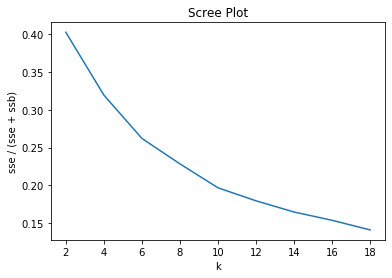

In [102]:
k_collection = [x for x in range(2, 20, 2)]
Eval_SKLearn_agg_scree(small_xy, k_collection)

CLUSTER SSE IS: [32.24772795411403, 25.22911100567976, 31.20294475079321, 27.592873393793326, 19.92423302517606, 17.463462019390224]
TOTAL SSE IS: 153.66035214894663
TOTAL SSB IS: 432.4894887114212
SSE RATIO: 0.26215199840948433


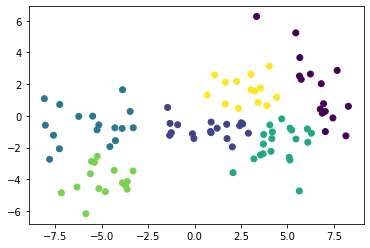

CROSS TABULATION MATRIX
	| c0	| c1	| c2	| c3	| c4	| c5	| predicted
c0	| 0	| 14	| 1	| 11	| 0	| 8	
c1	| 0	| 2	| 16	| 0	| 15	| 0	
c2	| 16	| 2	| 0	| 9	| 0	| 6	
actual




In [103]:
test_SKLearn_agg_small_large(small_xy, [6], k_special = 6)

## Evaluating on Large data set

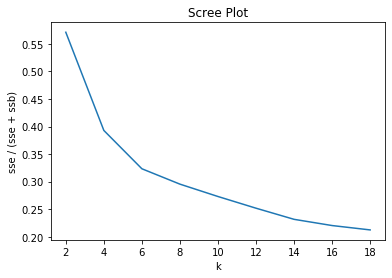

In [104]:
k_collection = [x for x in range(2, 20, 2)]
Eval_SKLearn_agg_scree(large_xy, k_collection)

CLUSTER SSE IS: [615.2491341845708, 456.39404810917864, 242.14940863136596, 302.81025070735035, 301.95288952523384, 107.75153420516443]
TOTAL SSE IS: 2026.3072653628628
TOTAL SSB IS: 4239.849418220331
SSE RATIO: 0.3233732202502402


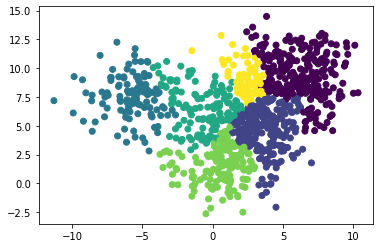

CROSS TABULATION MATRIX
	| c0	| c1	| c2	| c3	| c4	| c5	| predicted
c0	| 99	| 15	| 0	| 5	| 1	| 47	
c1	| 0	| 29	| 1	| 20	| 117	| 0	
c2	| 0	| 0	| 118	| 46	| 2	| 1	
c3	| 18	| 88	| 1	| 33	| 11	| 16	
c4	| 141	| 14	| 0	| 0	| 0	| 11	
c5	| 7	| 92	| 0	| 33	| 26	| 8	
actual




In [105]:
test_SKLearn_agg_small_large(large_xy, [6], k_special = 6)

## Evaluating on Red Wine data set

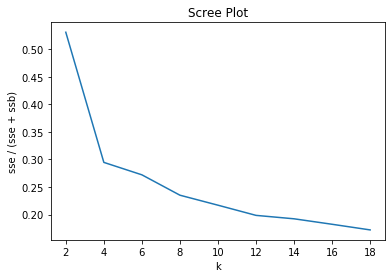

In [106]:
k_collection = [x for x in range(2, 20, 2)]
Eval_SKLearn_agg_scree(red_wine.drop(columns=['quality']), k_collection)

CLUSTER SSE IS: [4806.092560012689, 4724.766607466435, 5114.886149354945, 2770.9914134637097]
TOTAL SSE IS: 17416.736730297715
TOTAL SSB IS: 41716.80859601336
SSE RATIO: 0.29453225972142505
CROSS TABULATION MATRIX
	| c0	| c1	| c2	| c3	| predicted
c0	| 0	| 1	| 7	| 2	
c1	| 3	| 10	| 29	| 11	
c2	| 156	| 169	| 232	| 124	
c3	| 39	| 146	| 278	| 175	
c4	| 11	| 23	| 120	| 45	
c5	| 1	| 3	| 12	| 2	
actual




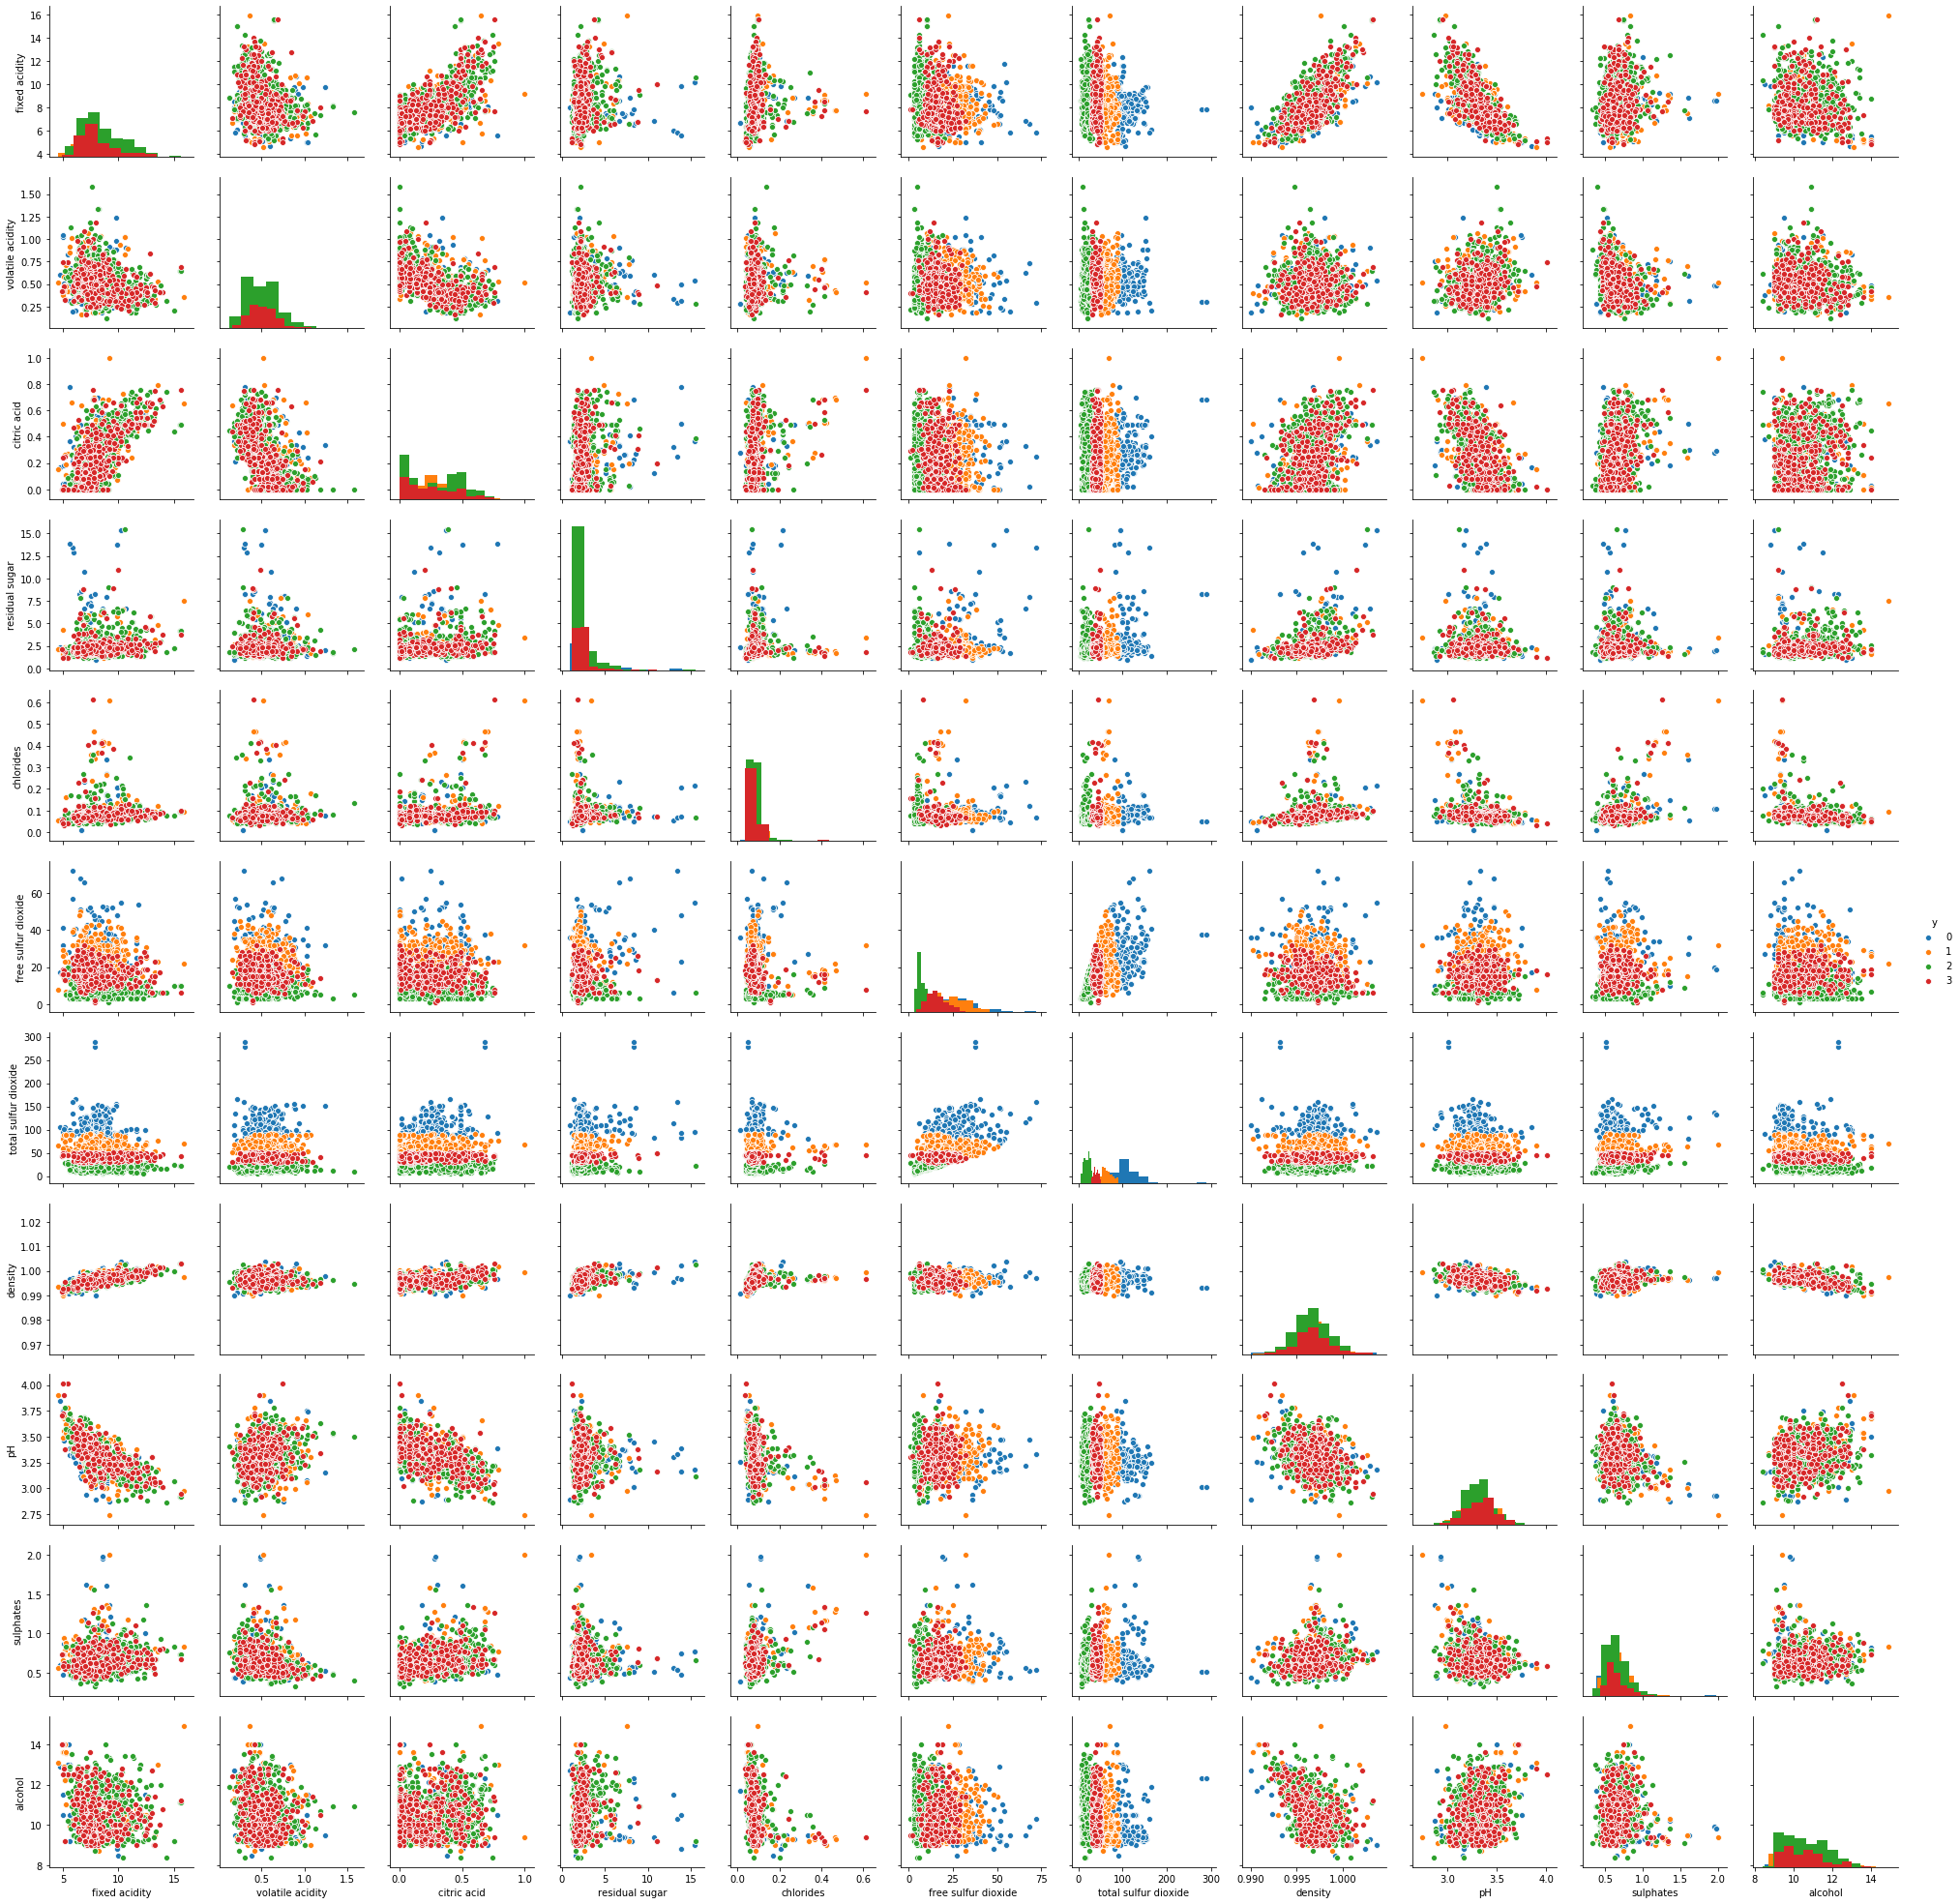

In [107]:
test_SKLearn_agg_redwine(red_wine, 4, k_special = 4)

# Ranking of results by SSE ratio

### Small data set

1. Sklearn K-Means

CLUSTER SSE IS: [25.113650316705517, 27.786510770471924, 28.88352039998379, 29.171406839346304, 23.197524969970992, 16.210872383529896]<br/>
TOTAL SSE IS: 150.36348568000844<br/>
TOTAL SSB IS: 434.4472418710884<br/>
SSE RATIO: 0.2571147870519709<br/>

2. Gaussian Mixture Model

CLUSTER SSE IS: [22.259240947405164, 19.92423302517606, 29.943740736444642, 26.036592357641275, 20.790905667554412, 34.93146095209374]<br/>
TOTAL SSE IS: 153.88617368631526<br/>
TOTAL SSB IS: 438.35478003475976<br/>
SSE RATIO: 0.25983710298898094<br/>

3. Agglomerative Clustering

CLUSTER SSE IS: [32.24772795411403, 25.22911100567976, 31.20294475079321, 27.592873393793326, 19.92423302517606, 17.463462019390224]<br/>
TOTAL SSE IS: 153.66035214894663<br/>
TOTAL SSB IS: 432.4894887114212<br/>
SSE RATIO: 0.26215199840948433<br/>

4. From scratch K-Means

CLUSTER SSE IS: [14.321048894655888, 23.197524969970992, 27.786510770471924, 19.443766260326196, 25.22911100567976, 47.97577893804139]<br/>
TOTAL SSE IS: 157.95374083914618<br/>
TOTAL SSB IS: 433.7257603360633<br/>
SSE RATIO: 0.26695827813100553<br/>

### Large data set

1. Agglomerative Clustering

CLUSTER SSE IS: [615.2491341845708, 456.39404810917864, 242.14940863136596, 302.81025070735035, 301.95288952523384, 107.75153420516443]<br/>
TOTAL SSE IS: 2026.3072653628628<br/>
TOTAL SSB IS: 4239.849418220331<br/>
SSE RATIO: 0.3233732202502402<br/>

2. From scratch K-Means

CLUSTER SSE IS: [662.0238124444755, 549.0543932592994, 389.12173771755505, 656.2668969006731]<br/>
TOTAL SSE IS: 2256.466840322003<br/>
TOTAL SSB IS: 3980.4496480032612<br/>
SSE RATIO: 0.36179205614598653<br/>

3. Gaussian Mixture Model

CLUSTER SSE IS: [376.6374562533373, 702.1533787373509, 544.9836781878048, 618.9660942181022]<br/>
TOTAL SSE IS: 2242.7406073965976<br/>
TOTAL SSB IS: 3938.3921164928233<br/>
SSE RATIO: 0.3628365070901396<br/>

4. Sklearn K-Means

CLUSTER SSE IS: [537.5157636165864, 666.3510261776227, 390.04468936603956, 646.4919803291158]<br/>
TOTAL SSE IS: 2240.403459489365<br/>
TOTAL SSB IS: 3891.086218694983<br/>
SSE RATIO: 0.36539300840065864<br/>

### Red Wine data set

1. Sklearn K-Means

CLUSTER SSE IS: [2471.767864327411, 3994.8735714567297, 3783.6483217172804, 11.0, 1116.7179271251641, 3297.3475044500997]<br/>
TOTAL SSE IS: 14675.35518907669<br/>
TOTAL SSB IS: 41888.52501338517<br/>
SSE RATIO: 0.25944746252464423<br/>

2. Agglomerative Clustering

CLUSTER SSE IS: [4806.092560012689, 4724.766607466435, 5114.886149354945, 2770.9914134637097]<br/>
TOTAL SSE IS: 17416.736730297715<br/>
TOTAL SSB IS: 41716.80859601336<br/>
SSE RATIO: 0.29453225972142505<br/>

3. Gaussian Mixture Model

CLUSTER SSE IS: [10954.087313831726, 3429.649604372425, 2638.962615217396, 1071.0795756489704, 660.6866912068739, 8562.14100201374]<br/>
TOTAL SSE IS: 27316.606802291084<br/>
TOTAL SSB IS: 39418.009047600324<br/>
SSE RATIO: 0.40933189551484517<br/>

4. From scratch K-Means

CLUSTER SSE IS: [10888.685381436475, 1496.5269048973569, 10536.206011510541, 34.022488281135466, 6280.87021648497, 749.2728542794449]<br/>
TOTAL SSE IS: 29985.58385688987<br/>
TOTAL SSB IS: 35692.36077359333<br/>
SSE RATIO: 0.456554845398932<br/>

# Summary

### Small data set

The number of clusters found in the ideal setting by analyzing the Scree plot is consistent across all algorithms. Sklearn K-means with k = 6 is the best model, with an SSE ratio of about 0.25. 

### Large data set

The Agglomerative clustering algorithm is the only one where I chose n_clusters = 6 to be ideal by Scree plot analysis. For all remaining algorithms I chose n_clusters = 4. The choice for the ideal k value fo sklearn K-Means was somewhat arbitrary between 4 and 6, either could probably been used. I'm less comfortable with the result here but given that the true number of clusters in the large data set is actually 6, my discomfort comes from the unknown reason that 4 clusters appeared better in all the other algorithms.

### Red Wine data set

The results of the Red Wine data set expiriment are interesting. For the Agglomerative Clustering algorithm the best number of clusters appears to be 4 but for all other algorithms the best appeared to be 6. However, even with only 4 groups the agglomerative algorthim has a much lower SSE ratio than from scratch K-means and the GMM. There is also a significant difference in the SSE ratio for sklearn and from scratch K-means that I can't readily explain considering the disparity was absent for the other two datasets. From scratch K-means must be running into trouble in this higher dimensional space. I would expect the GMM to be worse on this data set because some of our features are non-normal and highly skewed. I'm comfortable choosing sklearn K-Means as best on this dataset because the SSE ratio for agglomerative would still be higher had I chosen 6 clusters for it.

# Takeaways

This was my first time applying unsupervised clustering algorithms. I definitely understand the difficulty in evaluating the chosen clustering. A lot of evaluation feels ambiguous and in the future whenever applying such algorithms for things like feature creation or model deployment I'll likely attempt to evaluate multiple clusterings in to acheive my goal. 